Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress as reg_lin
from mesfonctions import scatter_plot
from mesfonctions import arrondi
from mesfonctions import display_scores
from mesfonctions import barh_plot_coefs

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from graphviz import Source
from sklearn.tree import export_graphviz


In [17]:
# pour développement only - cellule à supprimer du notebook final
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)
# from mesfonctions import xxx

## Gestion des paramètres d'affichage de Jupyter

In [3]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 160 sur ma config portable
np.set_printoptions(linewidth=160)

# affichage des objets sklearn
set_config(display='diagram')

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Fonctions en cours de développement (à déplacer ultérieurement dans un fichier .py externe)

## Chargement du pickle du df nettoyé

In [4]:
df1 = pd.read_pickle('df1_après_nettoyage_Projet_Seattle.pkl')

# Deuxième approche pour SiteEnergyUse : utilisation des surfaces des PropertyUseType

## Feature engineering

Pour chaque modalité de PropertyUseType, on ajoute une colonne au dataframe df1.  
Cette colonne contiendra la superficie pour la modalité considérée.  

##### Liste des modalités de PropertyUseType

In [5]:
ser_type1 = df1['LargestPropertyUseType'].value_counts()
ser_type2 = df1['SecondLargestPropertyUseType'].value_counts()
ser_type3 = df1['ThirdLargestPropertyUseType'].value_counts()
liste_modalites_types_1_2_3 = list(ser_type1.index) + list(ser_type2.index) + list(ser_type3.index)
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_modalites_types_1_2_3 = list(dict.fromkeys(liste_modalites_types_1_2_3))
liste_modalites_types_1_2_3

['Office',
 'Non-Refrigerated Warehouse',
 'K-12 School',
 'Retail Store',
 'Other',
 'Hotel',
 'Worship Facility',
 'Distribution Center',
 'Medical Office',
 'Supermarket/Grocery Store',
 'Other - Recreation',
 'Parking',
 'Self-Storage Facility',
 'College/University',
 'Residence Hall/Dormitory',
 'Other - Entertainment/Public Assembly',
 'Senior Care Community',
 'Laboratory',
 'Multifamily Housing',
 'Refrigerated Warehouse',
 'Restaurant',
 'Hospital (General Medical & Surgical)',
 'Social/Meeting Hall',
 'Manufacturing/Industrial Plant',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Strip Mall',
 'Other - Services',
 'Museum',
 'Fitness Center/Health Club/Gym',
 'Other - Lodging/Residential',
 'Automobile Dealership',
 'Urgent Care/Clinic/Other Outpatient',
 'Other/Specialty Hospital',
 'Other - Mall',
 'Other - Education',
 'Financial Office',
 'Library',
 'Bank Branch',
 'Performing Arts',
 'Data Center',
 'Prison/Incarceration',
 'Other - Utility',
 'Other - Public S

##### Ajout de colonne à df1 pour chaque PropertyUseType

In [6]:
# Création d'une liste contenant le nom des colonnes créés
liste_modalites_types_1_2_3_GFA = []

for moda in liste_modalites_types_1_2_3:
    nom_moda_GFA = moda + ' GFA'
    df1[nom_moda_GFA] = 0   # initialisation à 0 sq/f
    liste_modalites_types_1_2_3_GFA.append(nom_moda_GFA)

In [7]:
# création d'une liste contenant les variables créées
liste_variables_PropertyUseTypes_GFA = []
for moda in liste_modalites_types_1_2_3:
    liste_variables_PropertyUseTypes_GFA.append(moda + ' GFA')

##### Ajout des surfaces des PropertyUseType dans le dataframe df1

In [8]:
def ajout_surfaces(categorie):
    for indice, modalite, surface in zip(df1[categorie].index,
                                         df1[categorie],
                                         df1[categorie+'GFA']):
        if ~np.isnan(surface):
            df1.at[indice, modalite + ' GFA'] += surface
    
ajout_surfaces('LargestPropertyUseType')
ajout_surfaces('SecondLargestPropertyUseType')
ajout_surfaces('ThirdLargestPropertyUseType')

In [9]:
df1.sample(10, random_state=0)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions,Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Medical Office GFA,Supermarket/Grocery Store GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Multifamily Housing GFA,Refrigerated Warehouse GFA,Restaurant GFA,Hospital (General Medical & Surgical) GFA,Social/Meeting Hall GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Other - Services GFA,Museum GFA,Fitness Center/Health Club/Gym GFA,Other - Lodging/Residential GFA,Automobile Dealership GFA,Urgent Care/Clinic/Other Outpatient GFA,Other/Specialty Hospital GFA,Other - Mall GFA,Other - Education GFA,Financial Office GFA,Library GFA,Bank Branch GFA,Performing Arts GFA,Data Center GFA,Prison/Incarceration GFA,Other - Utility GFA,Other - Public Services GFA,Adult Education GFA,Other - Restaurant/Bar GFA,Pre-school/Daycare GFA,Lifestyle Center GFA,Movie Theater GFA,Courthouse GFA,Police Station GFA,Convention Center GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Wholesale Club/Supercenter GFA,Fire Station GFA,Food Service GFA,Residential Care Facility GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Vocational School GFA,Enclosed Mall GFA,Convenience Store without Gas Station GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA
2738,26761,NonResidential,Small- and Mid-Sized Office,98105.0,4,LAKE UNION,47.65373,-122.32721,2007,1.0,3,44510,18228,26282,Office,26282.0,Parking,18228.0,NaN,NaN,23.0,83.300003,85.599998,261.399994,268.899994,2.188051e+06,2.250450e+06,0.0,6.412810e+05,2188051.0,0.000000,0.0,15.25,0.34,15.253913,0.0,0.000000,26282,0,0,0,0,0,0,0,0,0,0,18228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1839,23562,NonResidential,Mixed Use Property,98104.0,7,DOWNTOWN,47.60195,-122.33516,1913,1.0,3,43878,0,43878,Multifamily Housing,12000.0,Office,8262.0,Retail Store,6312.0,NaN,23.400000,23.400000,73.500000,73.500000,7.697713e+05,7.697713e+05,0.0,2.256070e+05,769771.0,0.000000,0.0,5.37,0.12,5.366430,0.0,0.000000,8262,0,0,6312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1139,21088,NonResidential,Small- and Mid-Sized Office,98103.0,4,LAKE UNION,47.64904,-122.34609,1985,1.0,3,31417,8110,23307,Office,26295.0,Parking,12890.0,NaN,NaN,94.0,42.799999,46.200001,99.599998,102.099998,1.126157e+06,1.214409e+06,0.0,2.014866e+05,687472.0,4386.850098,438685.0,28.09,0.89,4.792687,0.0,23.298560,26295,0,0,0,0,0,0,0,0,0,0,12890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1043,20613,NonResidential,Warehouse,98134.0,2,GREATER DUWAMISH,47.56982,-122.33479,1951,1.0,1,24000,0,24000,Non-Refrigerated Warehouse,20400.0,Office,3600.0,NaN,NaN,NaN,52.400002,62.900002,93.000000,104.099998,1.257034e+06,1.510110e+06,0.0,1.278410e+05,436193.0,8208.400391,820840.0,46.64,1.94,3.040906,0.0,43.594812,3600,20400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##### Variable 'Somme types surfaces'

In [10]:
somme_types_surfaces = df1['LargestPropertyUseTypeGFA'].fillna(0) + df1['SecondLargestPropertyUseTypeGFA'].fillna(0) + df1['ThirdLargestPropertyUseTypeGFA'].fillna(0)
somme_types_surfaces.name = 'Somme types surfaces'
somme_types_surfaces.sample(10, random_state=0)

2738     44510.0
1839     26574.0
1139     39185.0
1043     24000.0
2076     36071.0
921      32960.0
444     125253.0
2411     22200.0
1734     20200.0
568      73563.0
Name: Somme types surfaces, dtype: float64

##### Corrélation entre les variables de surface des types de propriété

In [11]:
df_corr = df1[liste_modalites_types_1_2_3_GFA].corr()
print("Matrice de corrélation :")
display(df_corr)

Matrice de corrélation :


,Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Medical Office GFA,Supermarket/Grocery Store GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Multifamily Housing GFA,Refrigerated Warehouse GFA,Restaurant GFA,Hospital (General Medical & Surgical) GFA,Social/Meeting Hall GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Other - Services GFA,Museum GFA,Fitness Center/Health Club/Gym GFA,Other - Lodging/Residential GFA,Automobile Dealership GFA,Urgent Care/Clinic/Other Outpatient GFA,Other/Specialty Hospital GFA,Other - Mall GFA,Other - Education GFA,Financial Office GFA,Library GFA,Bank Branch GFA,Performing Arts GFA,Data Center GFA,Prison/Incarceration GFA,Other - Utility GFA,Other - Public Services GFA,Adult Education GFA,Other - Restaurant/Bar GFA,Pre-school/Daycare GFA,Lifestyle Center GFA,Movie Theater GFA,Courthouse GFA,Police Station GFA,Convention Center GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Wholesale Club/Supercenter GFA,Fire Station GFA,Food Service GFA,Residential Care Facility GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Vocational School GFA,Enclosed Mall GFA,Convenience Store without Gas Station GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA
Office GFA,1.000000,0.036940,-0.074705,0.035140,0.004315,-0.046124,-0.060109,-0.039895,-0.030189,-0.046716,-0.018454,0.536830,-0.035914,-0.011918,-0.025516,-0.016802,-0.021364,0.123019,0.007730,-0.006239,0.057303,-0.020593,-0.024285,-0.016450,-0.020122,-0.016869,-0.009519,-0.016193,0.004354,-0.012652,-0.018437,-0.013218,-0.017493,-0.009192,-0.007401,0.204144,-0.008817,-0.007914,0.002320,0.043240,-0.013693,-0.004007,-0.011571,-0.003291,0.001860,0.002829,-0.009613,-0.013097,-0.008962,-0.007903,-0.007903,-0.003264,-0.007903,-0.007903,0.014341,-0.007903,NaN,0.007793,-0.010262,-0.006765,0.000626,0.117136,0.073133,-0.007903
Non-Refrigerated Warehouse GFA,0.036940,1.000000,-0.053902,0.006255,-0.039559,-0.033203,-0.044375,0.004890,-0.028389,-0.034384,-0.013891,-0.065196,-0.025582,-0.008706,-0.019801,-0.012063,-0.015383,0.278546,-0.015276,0.411868,-0.032152,-0.014824,-0.019505,-0.012281,-0.011002,-0.012191,0.043905,-0.011657,-0.018315,-0.012656,-0.013447,-0.009515,-0.012593,-0.006617,-0.008406,-0.010101,-0.006347,-0.019268,-0.012144,-0.013798,-0.009857,-0.007338,-0.008617,-0.010090,-0.014311,-0.009724,-0.006920,-0.010056,-0.006451,-0.005689,-0.005689,-0.009157,-0.005689,-0.005689,-0.007221,-0.005689,NaN,-0.010662,-0.000038,-0.007265,-0.005689,-0.007941,-0.007898,-0.005689
K-12 School GFA,-0.074705,-0.053902,1.000000,-0.043081,-0.041744,-0.033169,-0.040975,-0.034002,-0.028242,-0.034695,-0.014167,-0.066181,-0.026205,-0.008697,-0.020145,-0.012174,-0.015190,-0.016966,-0.017510,-0.013858,-0.032350,-0.014809,-0.017400,-0.012268,-0.015043,-0.012178,-0.016839,-0.011645,-0.018297,-0.012643,-0.013433,-0.009505,-0.012580,-0.006610,-0.013371,-0.010090,-0.006340,-0.019248,-0.012132,-0.013791,-0.009847,-0.007331,-0.008608,-0.010080,-0.014296,-0.009714,-0.006913,-0.010046,-0.006445,-0.005683,-0.005683,-0.009147,-0.005683,-0.005683,-0.013706,-0.005683,NaN,-0.010651,-0.008016,-0.007258,-0.005683,-0.007933,-0.007889,-0.005683
Retail Store GFA,0.035140,0.006255,-0.043081,1.000000,0.106556,-0.025463,-0.035651,-0.025941,-0.016660,0.004190,-0.010965,0.017576,-0.020972,-0.006961,-0.014808,-0.009656,-0.012299,-0.013578,-0.009226,-0.011090,0.051074,-0.011852,-0.013362,-0.009003,-0.010530,-0.009746,-0.011405,-0.009320,-0.014359,-0.010119,-0.010751,-0.007607,-0.010068,-0.005290,-0.010701,-0.008075,-0.005074,-0.014008,-0.000253,-0.010481,-0.007881,-0.005867,-0.006889,-0.008067,0.015785,-0.007775,-0.005533,-0.008040,-0.005158,-0.004549,-0.004549,-0.004694,-0.004549,-0.0045

### Heatmap :

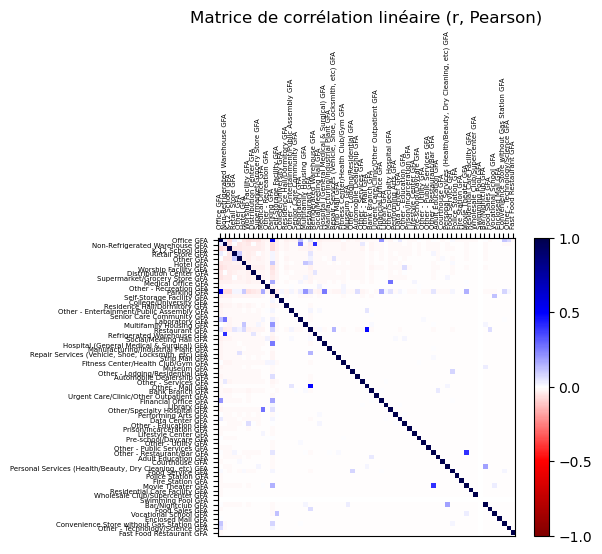

In [24]:
plt.style.use('default')
plt.matshow(df_corr, cmap='seismic_r', vmin=-1, vmax=1)
ticks = range(len(df_corr.columns))
plt.xticks(ticks,
           fontsize=5,
           labels=df_corr.columns,
           rotation=90)
plt.yticks(ticks, fontsize=5, labels=df_corr.columns)
plt.tick_params(bottom=False)
plt.colorbar(shrink=0.8, ticks=[-1, -0.5, 0, 0.5, 1])
plt.title('Matrice de corrélation linéaire (r, Pearson)')
plt.show()

Affichage des coefficients r triés :

In [25]:
df_corr_2 = pd.DataFrame(columns=['corrélation', 'var1', 'var2'])    # dataframe à 3 colonnes : 'corrélation', 'var1', 'var2'
for i in range(df_corr.shape[0]):
    for j in range(i):
        df_corr_2 = df_corr_2.append({'corrélation': df_corr.iloc[i,j], 'var1': df_corr.columns[i], 'var2': df_corr.columns[j]}, ignore_index=True)
df_corr_2 = df_corr_2.sort_values('corrélation', ascending=False, inplace=False)
df_corr_2 = df_corr_2.reset_index(drop=True)
df_corr_2.dropna(subset=['corrélation'], inplace=True)

In [26]:
df_corr_2.head(50)

,corrélation,var1,var2
0,0.569861,Parking GFA,Office GFA
1,0.490614,Other - Mall GFA,Restaurant GFA
2,0.411846,Refrigerated Warehouse GFA,Non-Refrigerated Warehouse GFA
3,0.399859,Movie Theater GFA,Other - Restaurant/Bar GFA
4,0.278451,Laboratory GFA,Non-Refrigerated Warehouse GFA
5,0.274954,Other/Specialty Hospital GFA,Medical Office GFA
6,0.259069,Hospital (General Medical & Surgical) GFA,Parking GFA
7,0.204518,Multifamily Housing GFA,Parking GFA
8,0.204109,Financial Office GFA,Office GFA
9,0.184884,Bar/Nightclub GFA,"Personal Services (Health/Beauty, Dry Cleaning..."


In [27]:
df_corr_2.tail(10)

,corrélation,var1,var2
1881,-0.043129,Parking GFA,Distribution Center GFA
1882,-0.044883,Worship Facility GFA,Non-Refrigerated Warehouse GFA
1883,-0.046659,Hotel GFA,Office GFA
1884,-0.047275,Supermarket/Grocery Store GFA,Office GFA
1885,-0.050800,K-12 School GFA,Non-Refrigerated Warehouse GFA
1886,-0.055181,Parking GFA,Worship Facility GFA
1887,-0.060832,Worship Facility GFA,Office GFA
1888,-0.064020,Parking GFA,K-12 School GFA
1889,-0.067733,Parking GFA,Non-Refrigerated Warehouse GFA
1890,-0.070408,K-12 School GFA,Office GFA


Conclusion sur les corrélations :  
les corrélations entre variables sont rares (la heatmap est blanche sauf sur la diagonale et quelques rares occurences de corrélation).

### Sauvegarde du df1 contenant les PropertyUseTypeGFA

In [12]:
df1.to_pickle('df1_après_nettoyage_avec_PropertyUseTypeGFA.pkl')

## Train test split 

POUR LE NOTEBOOK FINAL IL FAUDRA FAIRE LE SPLIT PLUS TOT (avant le nettoyage)  
IL FAUDRA FAIRE LE MEME NETTOYAGE SUR LES JEUX TRAIN ET TEST

POUR L'INSTANT ON NE TRAVAILLE QU'A LA PREDICTION DE SiteEUI(kBtu/sf)

##### Suppression des lignes pour lesquelles la variable 'SiteEUI(kBtu/sf)' n'est pas renseignée

In [15]:
df1 = df1.dropna(subset=['SiteEUI(kBtu/sf)']).copy()

##### Variable à prédire :

In [ ]:
y2 = df1[['SiteEnergyUse(kBtu)']].copy()

##### Variables explicatives :

In [ ]:
X2 = df1[liste_variables_PropertyUseTypes_GFA].copy()

##### Split :

In [ ]:
X_train_EU, X_test_EU, y_train_EU, y_test_EU = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [ ]:
y_train_EU

In [ ]:
X_train_EU

## Imputation, one-hot encoding, recalibrage

Imputation : non pertinent.  
One-hot encoding : non pertinent car toutes les variables sont quantitatives.  
Recalibrage : non pertinent, on part sur l'hypothèse que l'EnergyUse est proportionnel à la surface.  

## Dummy Regressor

In [ ]:
moyenne = y_train_EU.mean()
arrondi(moyenne, puissance10=6)

In [ ]:
ecart_type = y_train_EU.std()
arrondi(ecart_type, puissance10=6)

In [ ]:
zipped = zip(["mean", "median", "quantile", "constant"], [None, None, 0.8, None], [None, None, None, moyenne])
for strategy, quantile, constant in zipped:
    print("Stratégie :", strategy, "/", quantile, constant)
    dum_reg = DummyRegressor(strategy=strategy, quantile=quantile, constant=constant)
    dum_reg.fit(X_train_EU, y_train_EU)
    EU_predictions = dum_reg.predict(X_train_EU)
    print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

##### Prédiction sur y_test

In [ ]:
dum_reg = DummyRegressor(strategy='mean')
dum_reg.fit(X_train_EU, y_train_EU)
print(arrondi(dum_reg.score(X_test_EU, y_test_EU), 5))

##### Cross validation

In [ ]:
dum_reg = DummyRegressor(strategy='mean')
dum_scores = cross_val_score(dum_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
display_scores(dum_scores, 2)

## Régression linéaire simple

In [ ]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EU, y_train_EU)

In [ ]:
# Test de quelques valeurs prédites
some_data = X_train_EU.iloc[:100]
some_labels = y_train_EU.iloc[:100].copy()
some_data_predicted = lin_reg.predict(some_data)

some_labels['Prédictions'] = some_data_predicted
some_labels.head(10)

### Metrics

##### RMSE :

In [ ]:
EU_predictions = lin_reg.predict(X_train_EU)
lin_mse = mean_squared_error(y_train_EU, EU_predictions)
lin_rmse = np.sqrt(lin_mse)
arrondi(lin_rmse, puissance10=6)

##### MAE :

In [ ]:
lin_mae = mean_absolute_error(y_train_EU, EU_predictions)
arrondi(lin_mae, puissance10=6)

##### R² :

In [ ]:
#R² par la méthode score() du transformateur
arrondi(lin_reg.score(X_train_EU, y_train_EU), 5)

In [ ]:
#R² par la fonction r2_score de metrics
arrondi(r2_score(y_train_EU, EU_predictions))

### Cross validation

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

On passe de RMSE=6.8e6 (validation sur le jeu d'entraînement) à 10.7e6 (validation croisée) en moyenne.  
On passe de R²=0.95 (validation sur le jeu d'entraînement) à 0.68 (validation croisée) en moyenne.  

### Généralisation du modèle sur y_test

In [ ]:
EU_predictions = lin_reg.predict(X_test_EU)
#R² par la fonction r2_score de metrics
print(arrondi(r2_score(y_test_EU, EU_predictions), 5))

##### Scatter plot

In [ ]:
ser_predictions = pd.Series(np.squeeze(EU_predictions), name='Prédictions')
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e7, min_y = -0.1e7, max_y=1e7, ligne_diagonale=True)

### Analyse des paramètres du modèle

In [ ]:
arrondi(lin_reg.intercept_, puissance10=6)

In [ ]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

In [ ]:
coefs

In [ ]:
liste_effectif = []
for moda in liste_modalites_types_1_2_3:
    effectif = len(df1[moda+' GFA'][df1[moda+' GFA']!=0])
    liste_effectif.append(effectif)
df_coefs = pd.DataFrame(liste_effectif, columns=['Effectif'], index=liste_modalites_types_1_2_3)

In [ ]:
df_coefs['Coef NR LR'] = coefs.T
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef NR LR', ascending=False))

In [ ]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR LR', ascending=True).iloc[:, 1], effectif_array=df_coefs.sort_values(by='Coef NR LR', ascending=True).iloc[:, 0])

## Recalibrage des variables

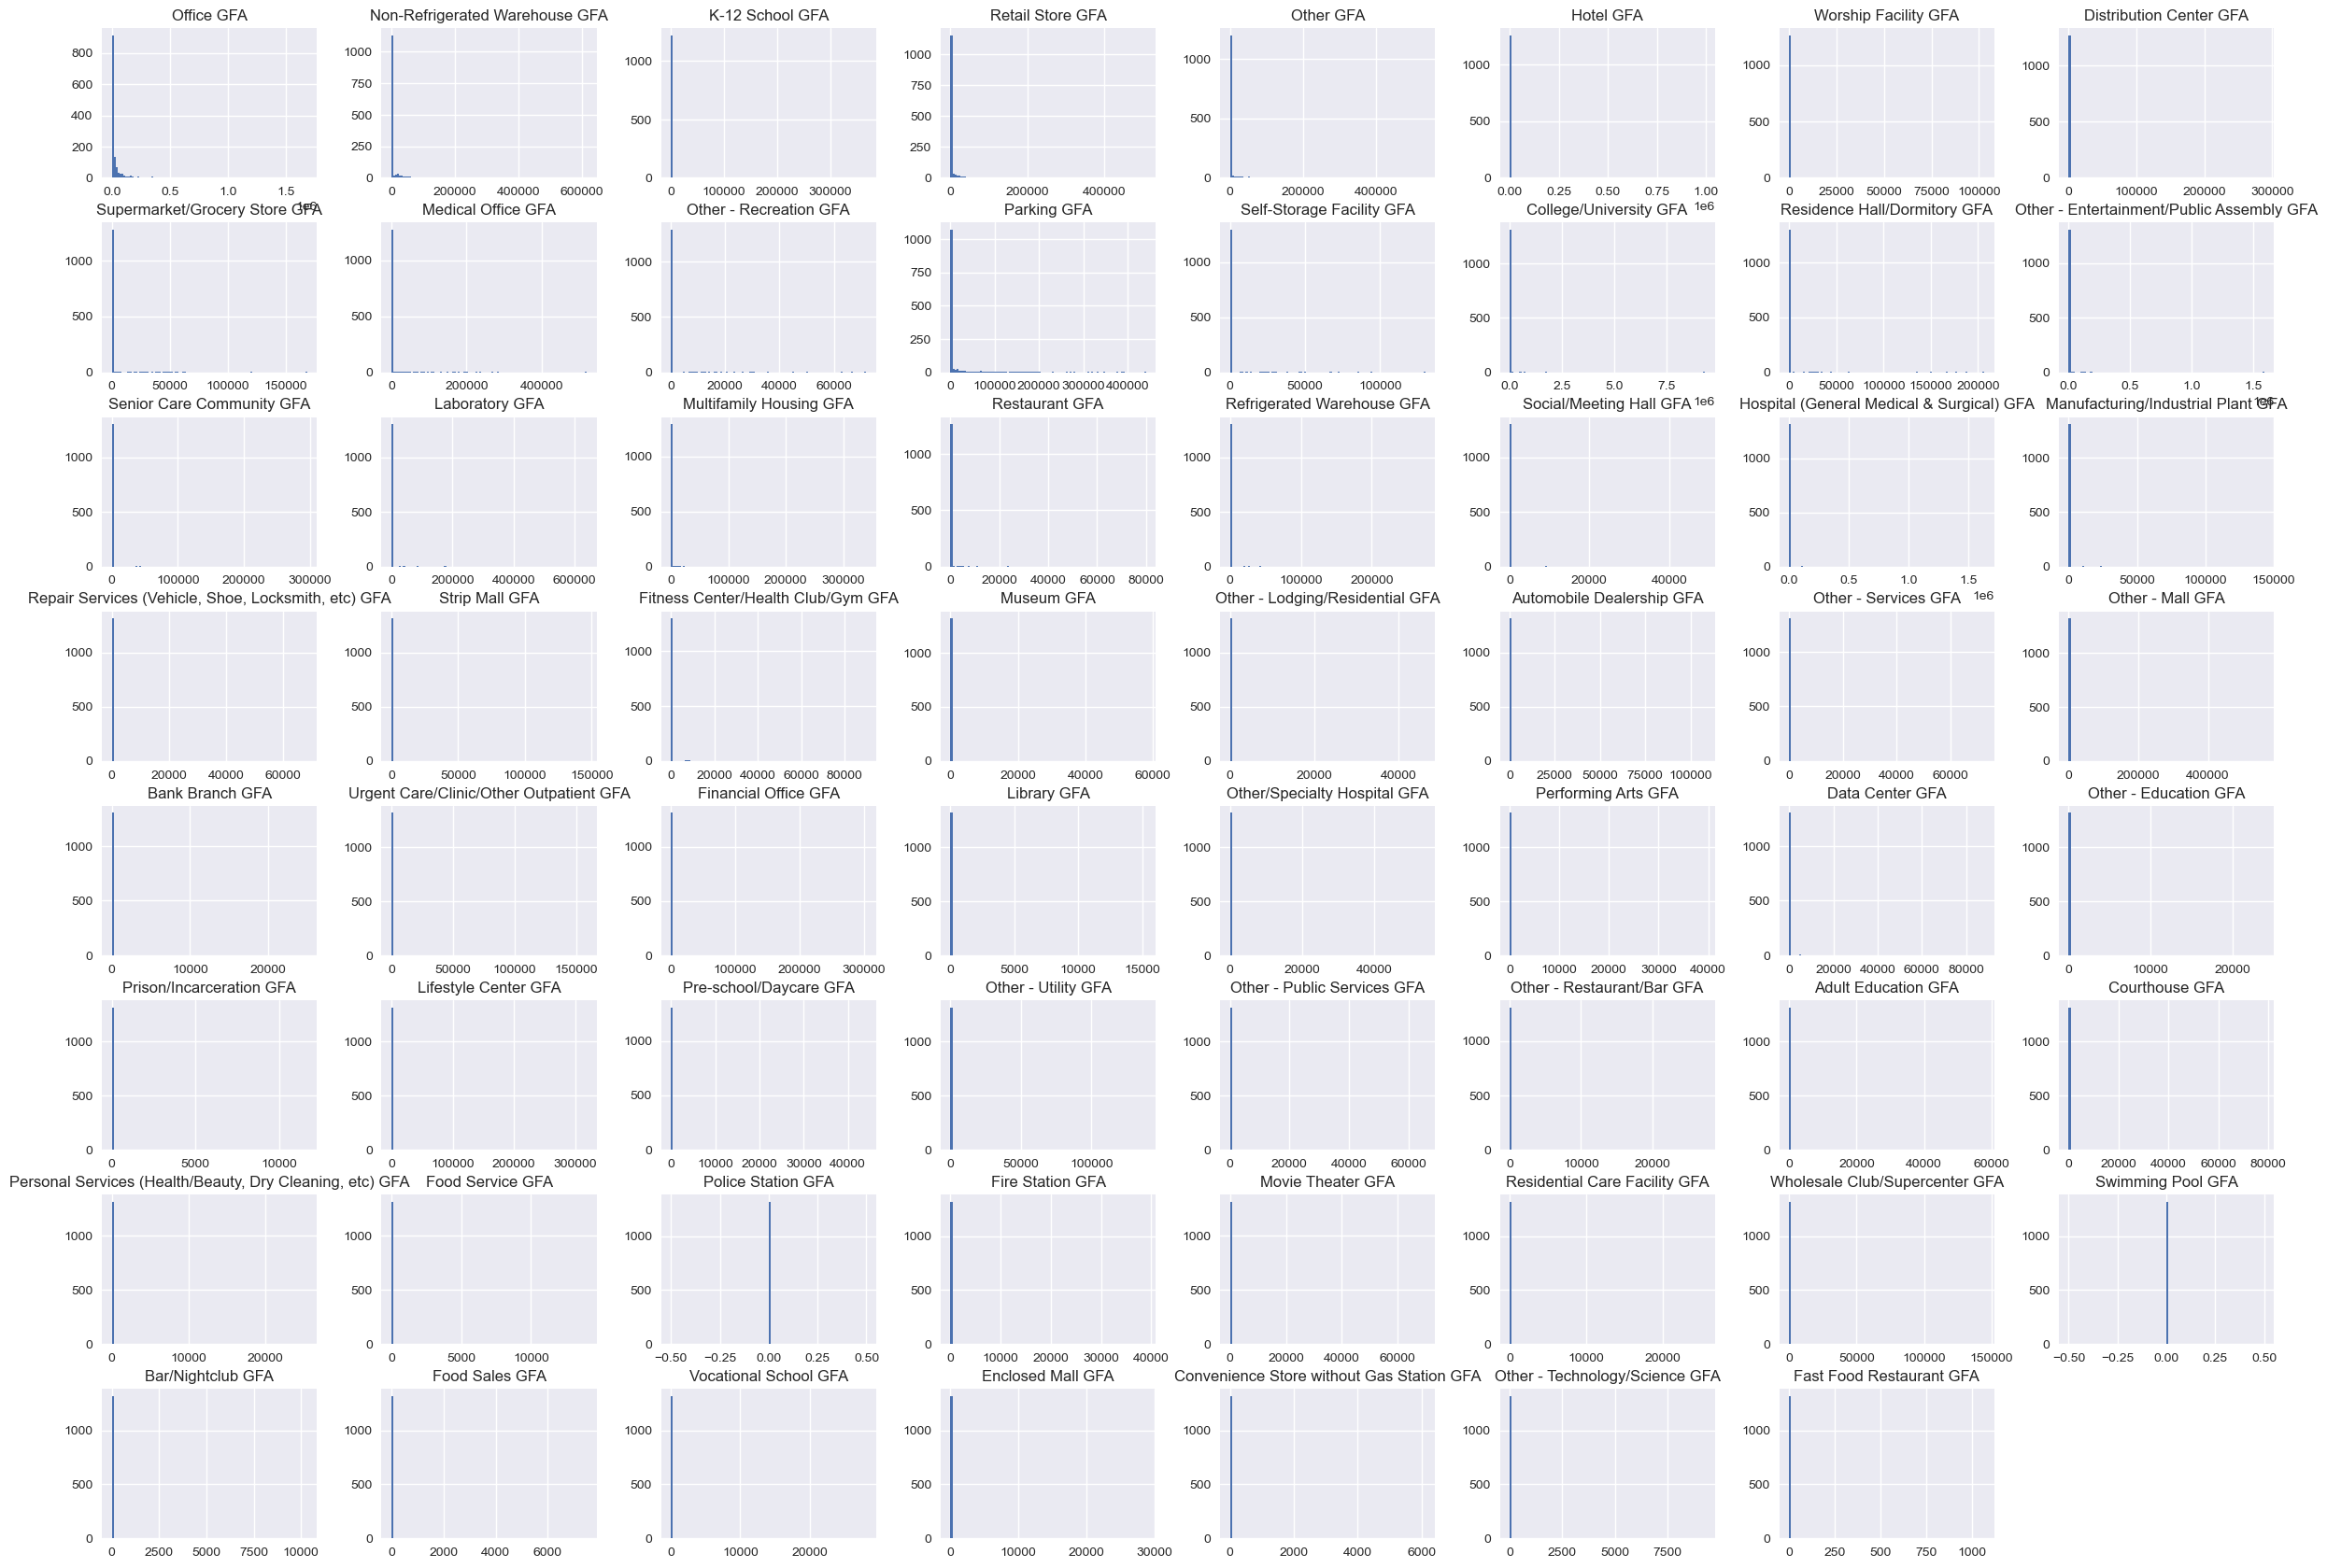

In [65]:
# Tracé des variables quantitatives avant recalibrage
plt.style.use('seaborn')
X_train_EU.hist(bins=100, figsize=(30,21))
plt.show()

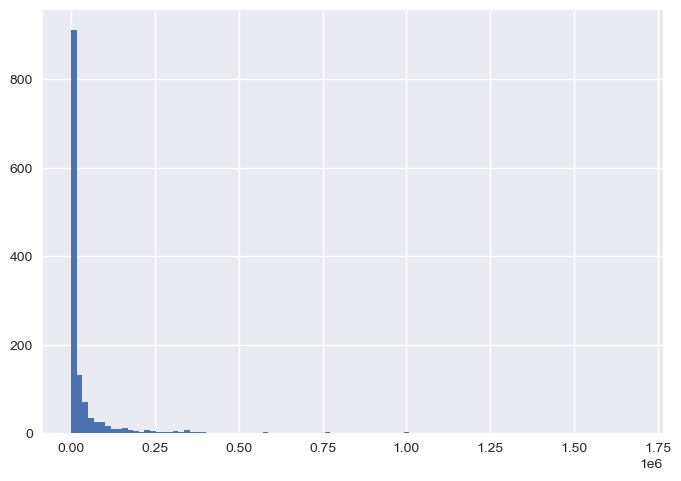

In [66]:
X_train_EU['Office GFA'].hist(bins=100)
plt.show()

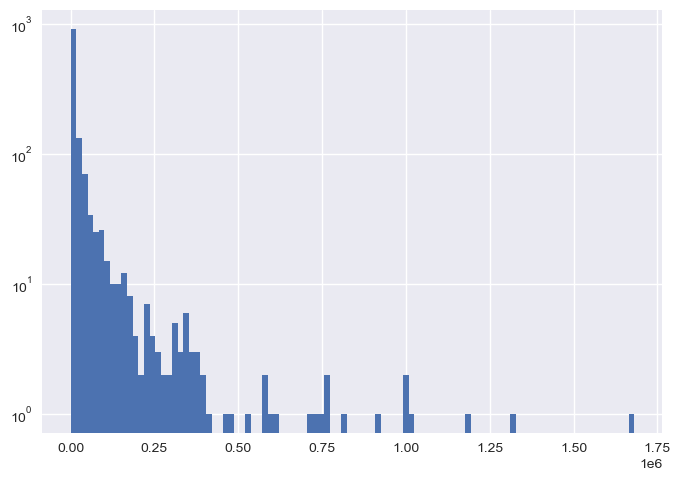

In [67]:
X_train_EU['Office GFA'].hist(bins=100, log=True);

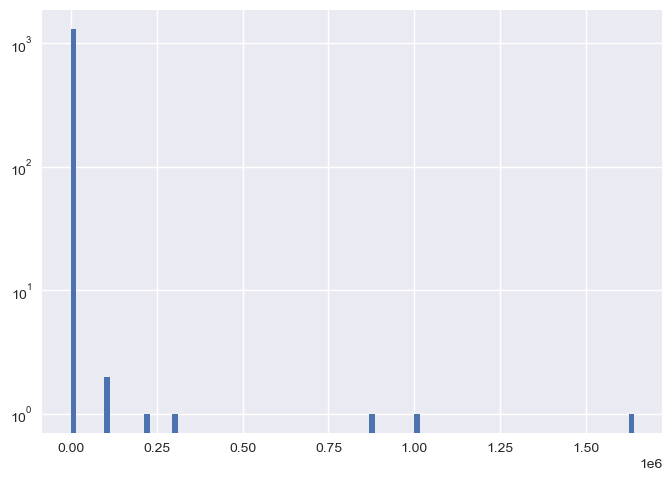

In [68]:
X_train_EU['Hospital (General Medical & Surgical) GFA'].hist(bins=100, log=True);

Histogrammes avec forte densité sur GFA=0 car une grande proportion de variables vaut 0.  
Rappel : il y a **{{X_train_EU.shape[0]}}** lignes dans le dataframe X_train_EU.

### Transformation = QuantileTransformer

In [ ]:
qt = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_train_EU_qt = qt.fit_transform(X_train_EU)

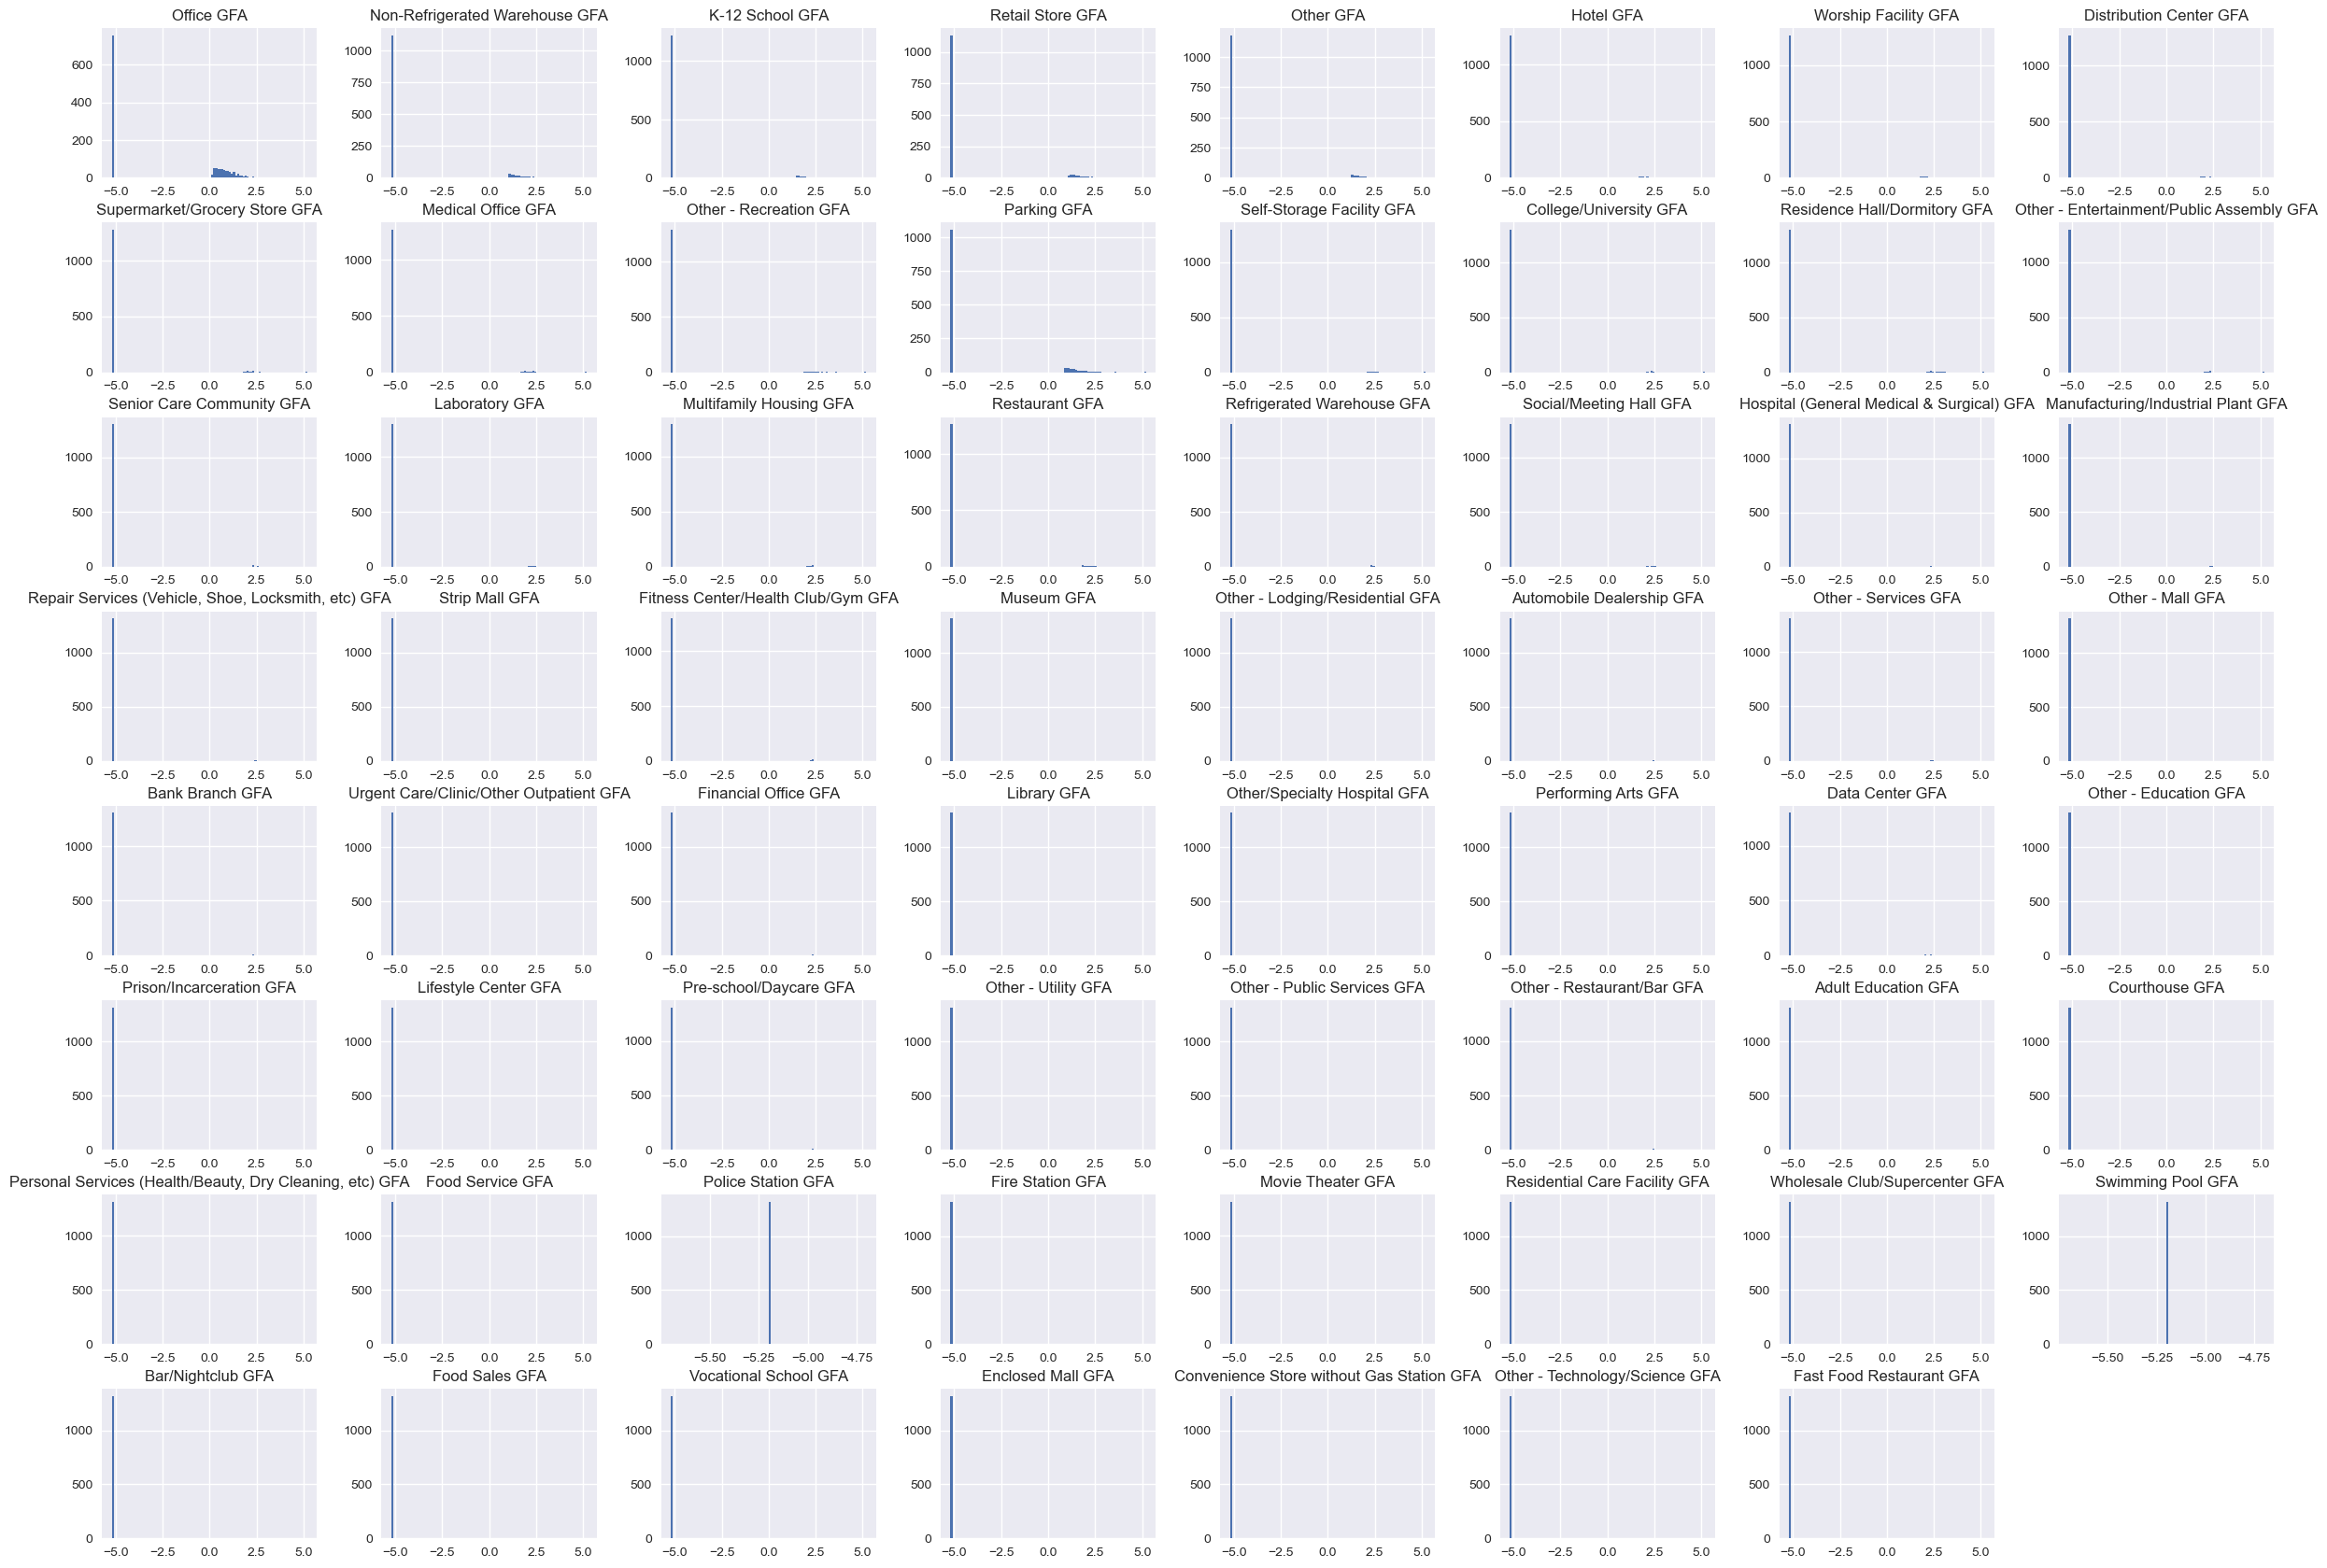

In [70]:
# Tracé des variables quantitatives après recalibrage
df_qt = pd.DataFrame(X_train_EU_qt, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_qt.hist(bins=100, figsize=(30,21));

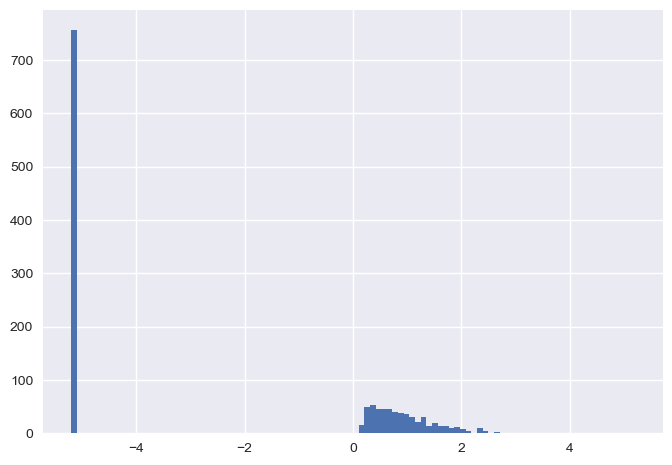

In [71]:
df_qt['Office GFA'].hist(bins=100);

##### Régression linéaire simple :

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_qt, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_qt)
print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

### Transformation = StandardScaler

In [ ]:
ss = StandardScaler()
X_train_EU_ss = ss.fit_transform(X_train_EU)
X_test_EU_ss = ss.transform(X_test_EU)

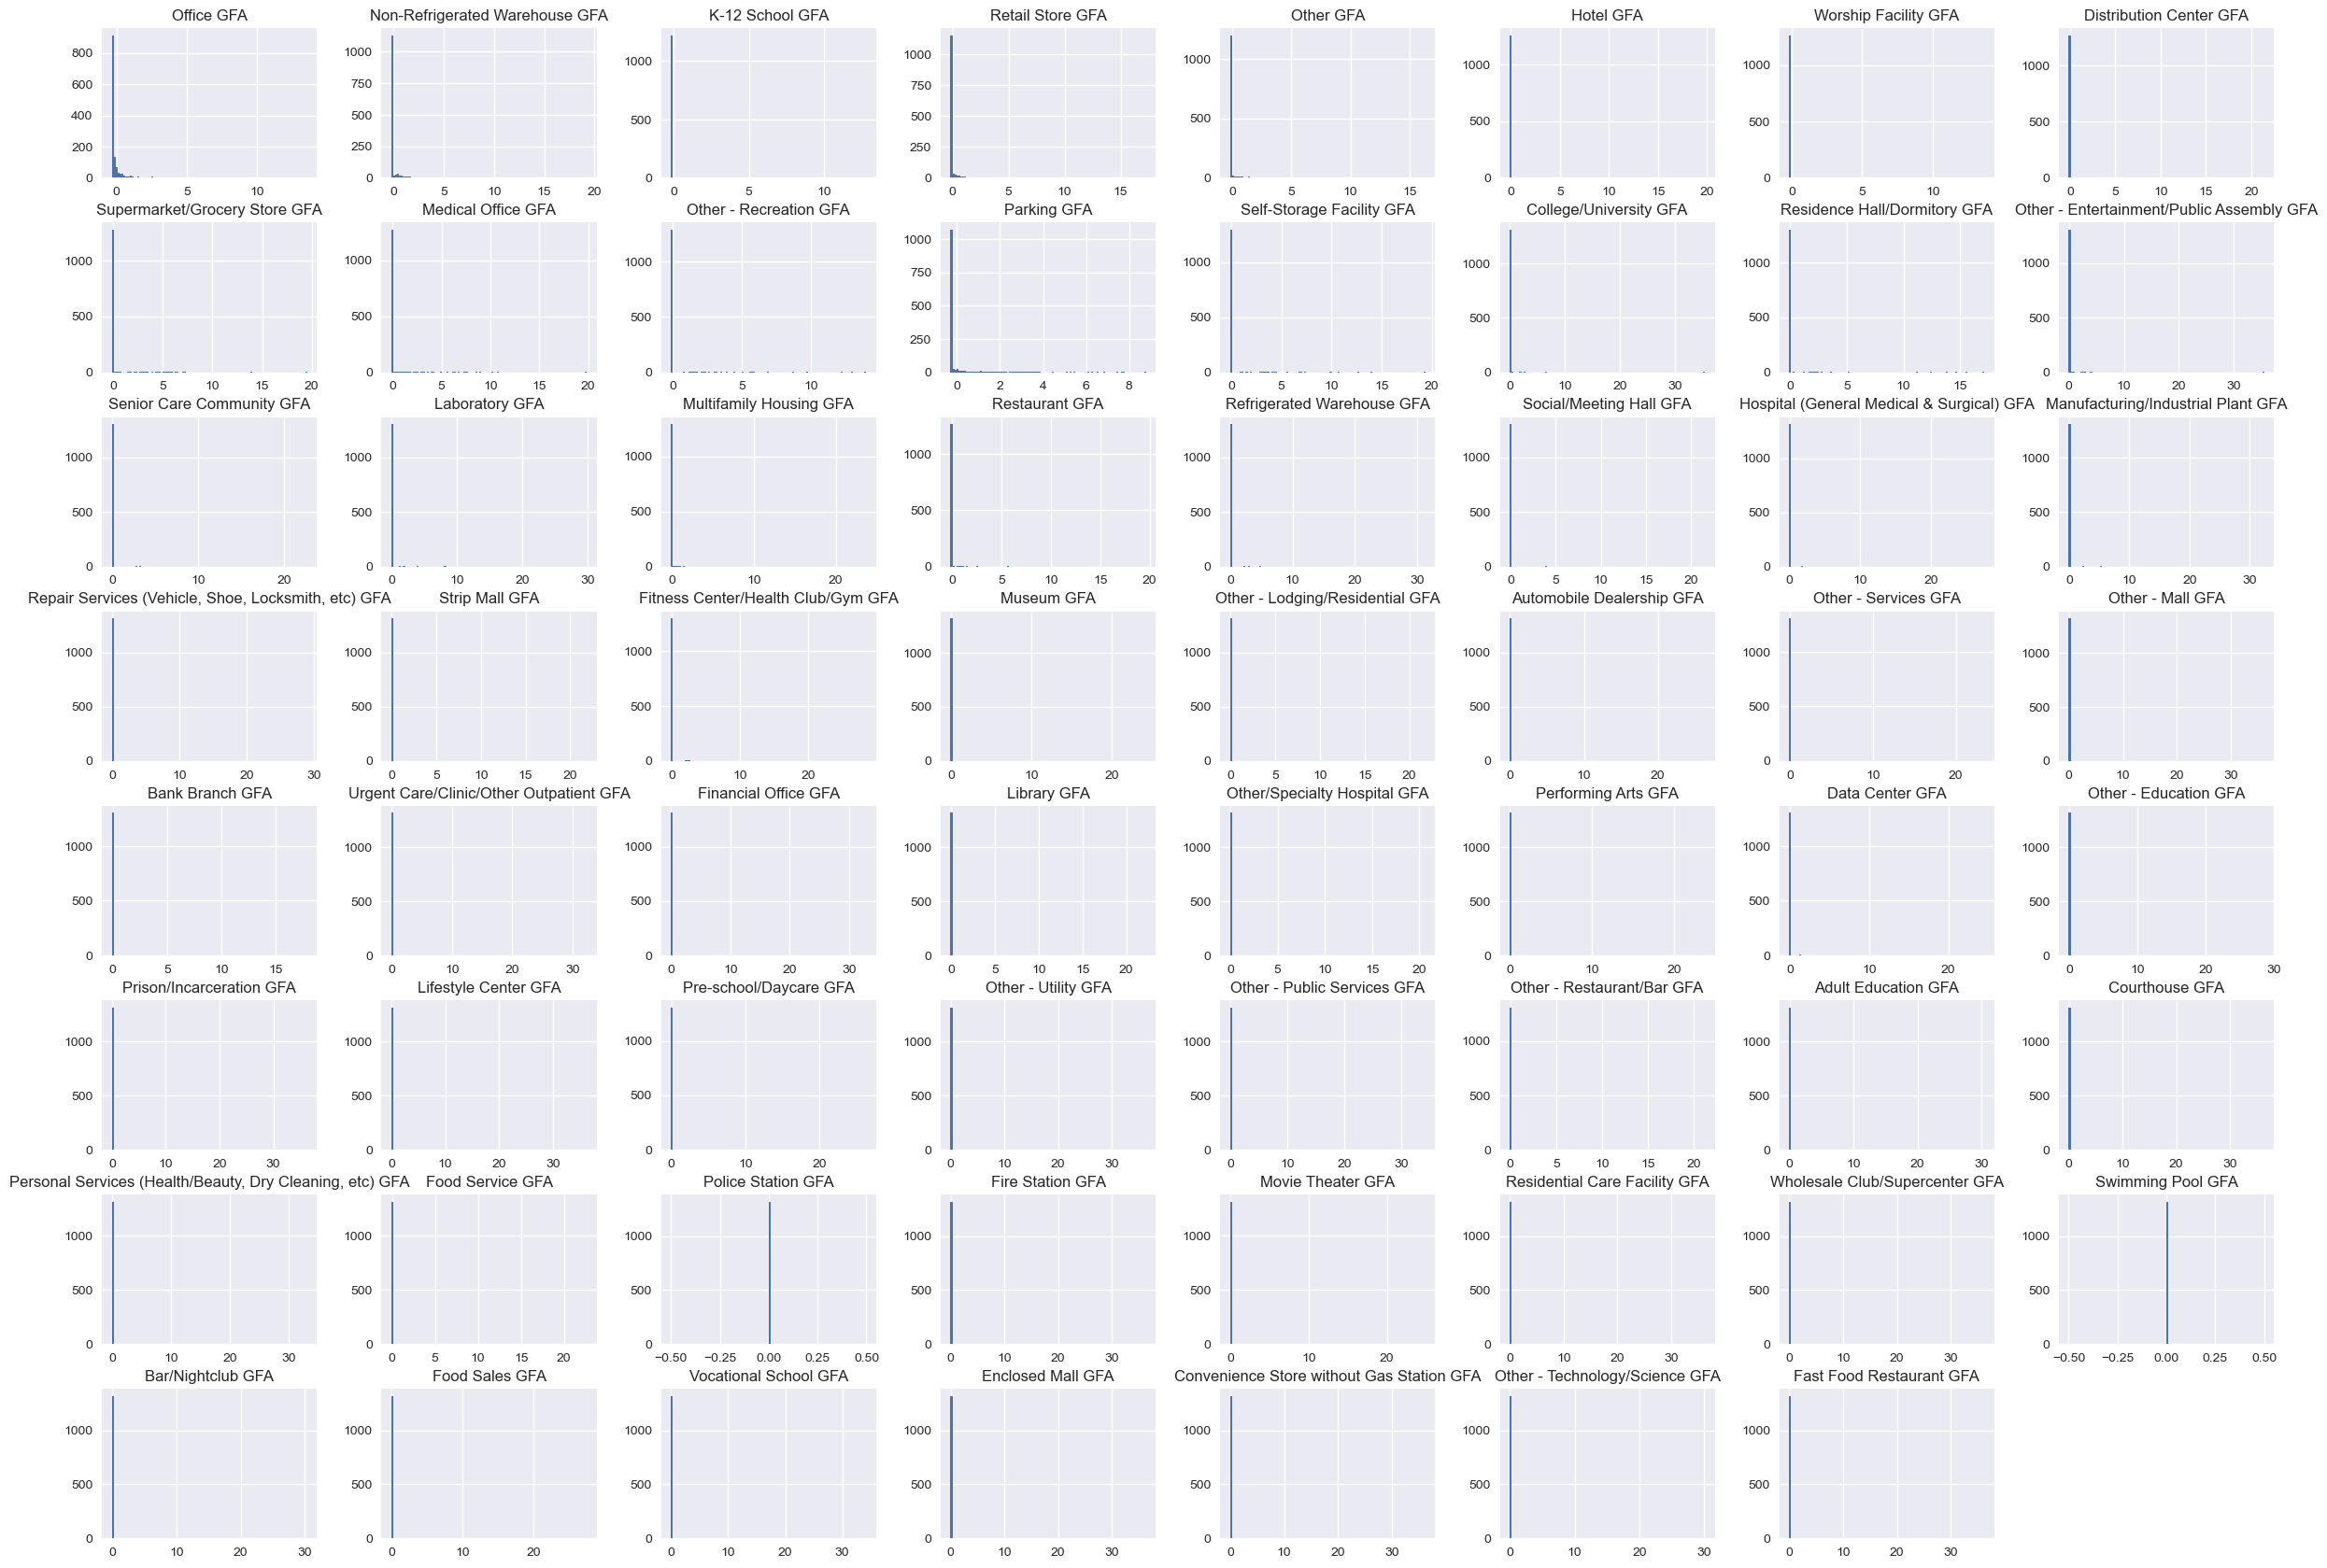

In [75]:
# Tracé des variables quantitatives après recalibrage
df_ss = pd.DataFrame(X_train_EU_ss, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_ss.hist(bins=100, figsize=(30,21));

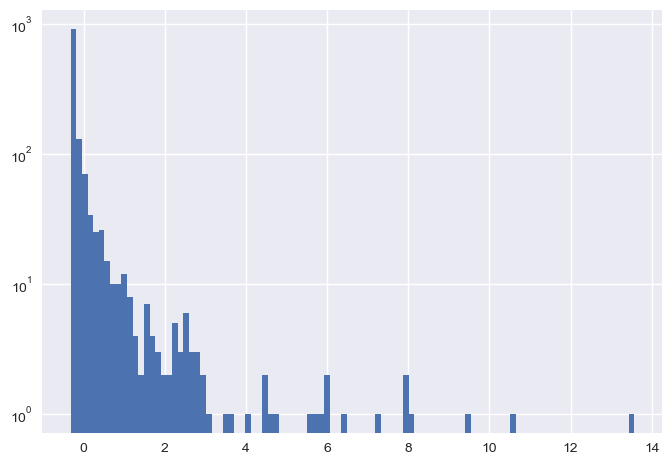

In [76]:
df_ss['Office GFA'].hist(bins=100, log=True);

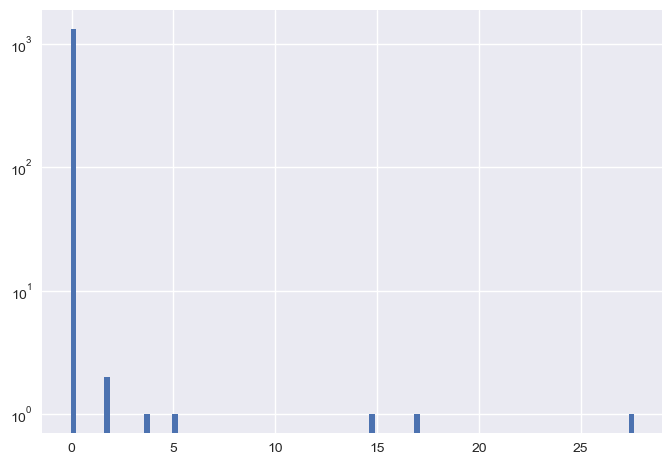

In [77]:
df_ss['Hospital (General Medical & Surgical) GFA'].hist(bins=100, log=True);

##### Régression linéaire simple :

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_ss, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_ss)

print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

print("RMSE =", arrondi(np.sqrt(mean_squared_error(y_train_EU, EU_predictions)), puissance10=6))

Comme attendu, on retrouve le même R² que pour la régression linéaire simple sans scaler, car le scaler fait une transformation linéaire.

In [ ]:
arrondi(lin_reg.intercept_, puissance10=6)

In [ ]:
lin_reg.coef_

In [ ]:
df_coefs['Coef SS LR'] = lin_reg.coef_.T

In [ ]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS LR', ascending=False))

In [ ]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS LR', ascending=True).loc[:, 'Coef SS LR'], effectif_array=df_coefs.sort_values(by='Coef SS LR', ascending=True).iloc[:, 0])

##### Cross validation

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU_ss, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU_ss, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Théoriquement, pour ces résultats de cross-validation (RMSE et R²), on devrait retrouver les mêmes résultats que pour la cross-validation sur le jeu de données non recalibré. Il y a vraisemblablement un bug !  A priori le pb vient de coefs non nuls sur des variables avec 0 donnée. Les disparaissent avec le Lasso.

### Transformation = MinMaxScaler

In [ ]:
mms = MinMaxScaler(feature_range=(0,1))
X_train_EU_mms = mms.fit_transform(X_train_EU)
X_test_EU_mms = mms.transform(X_test_EU)

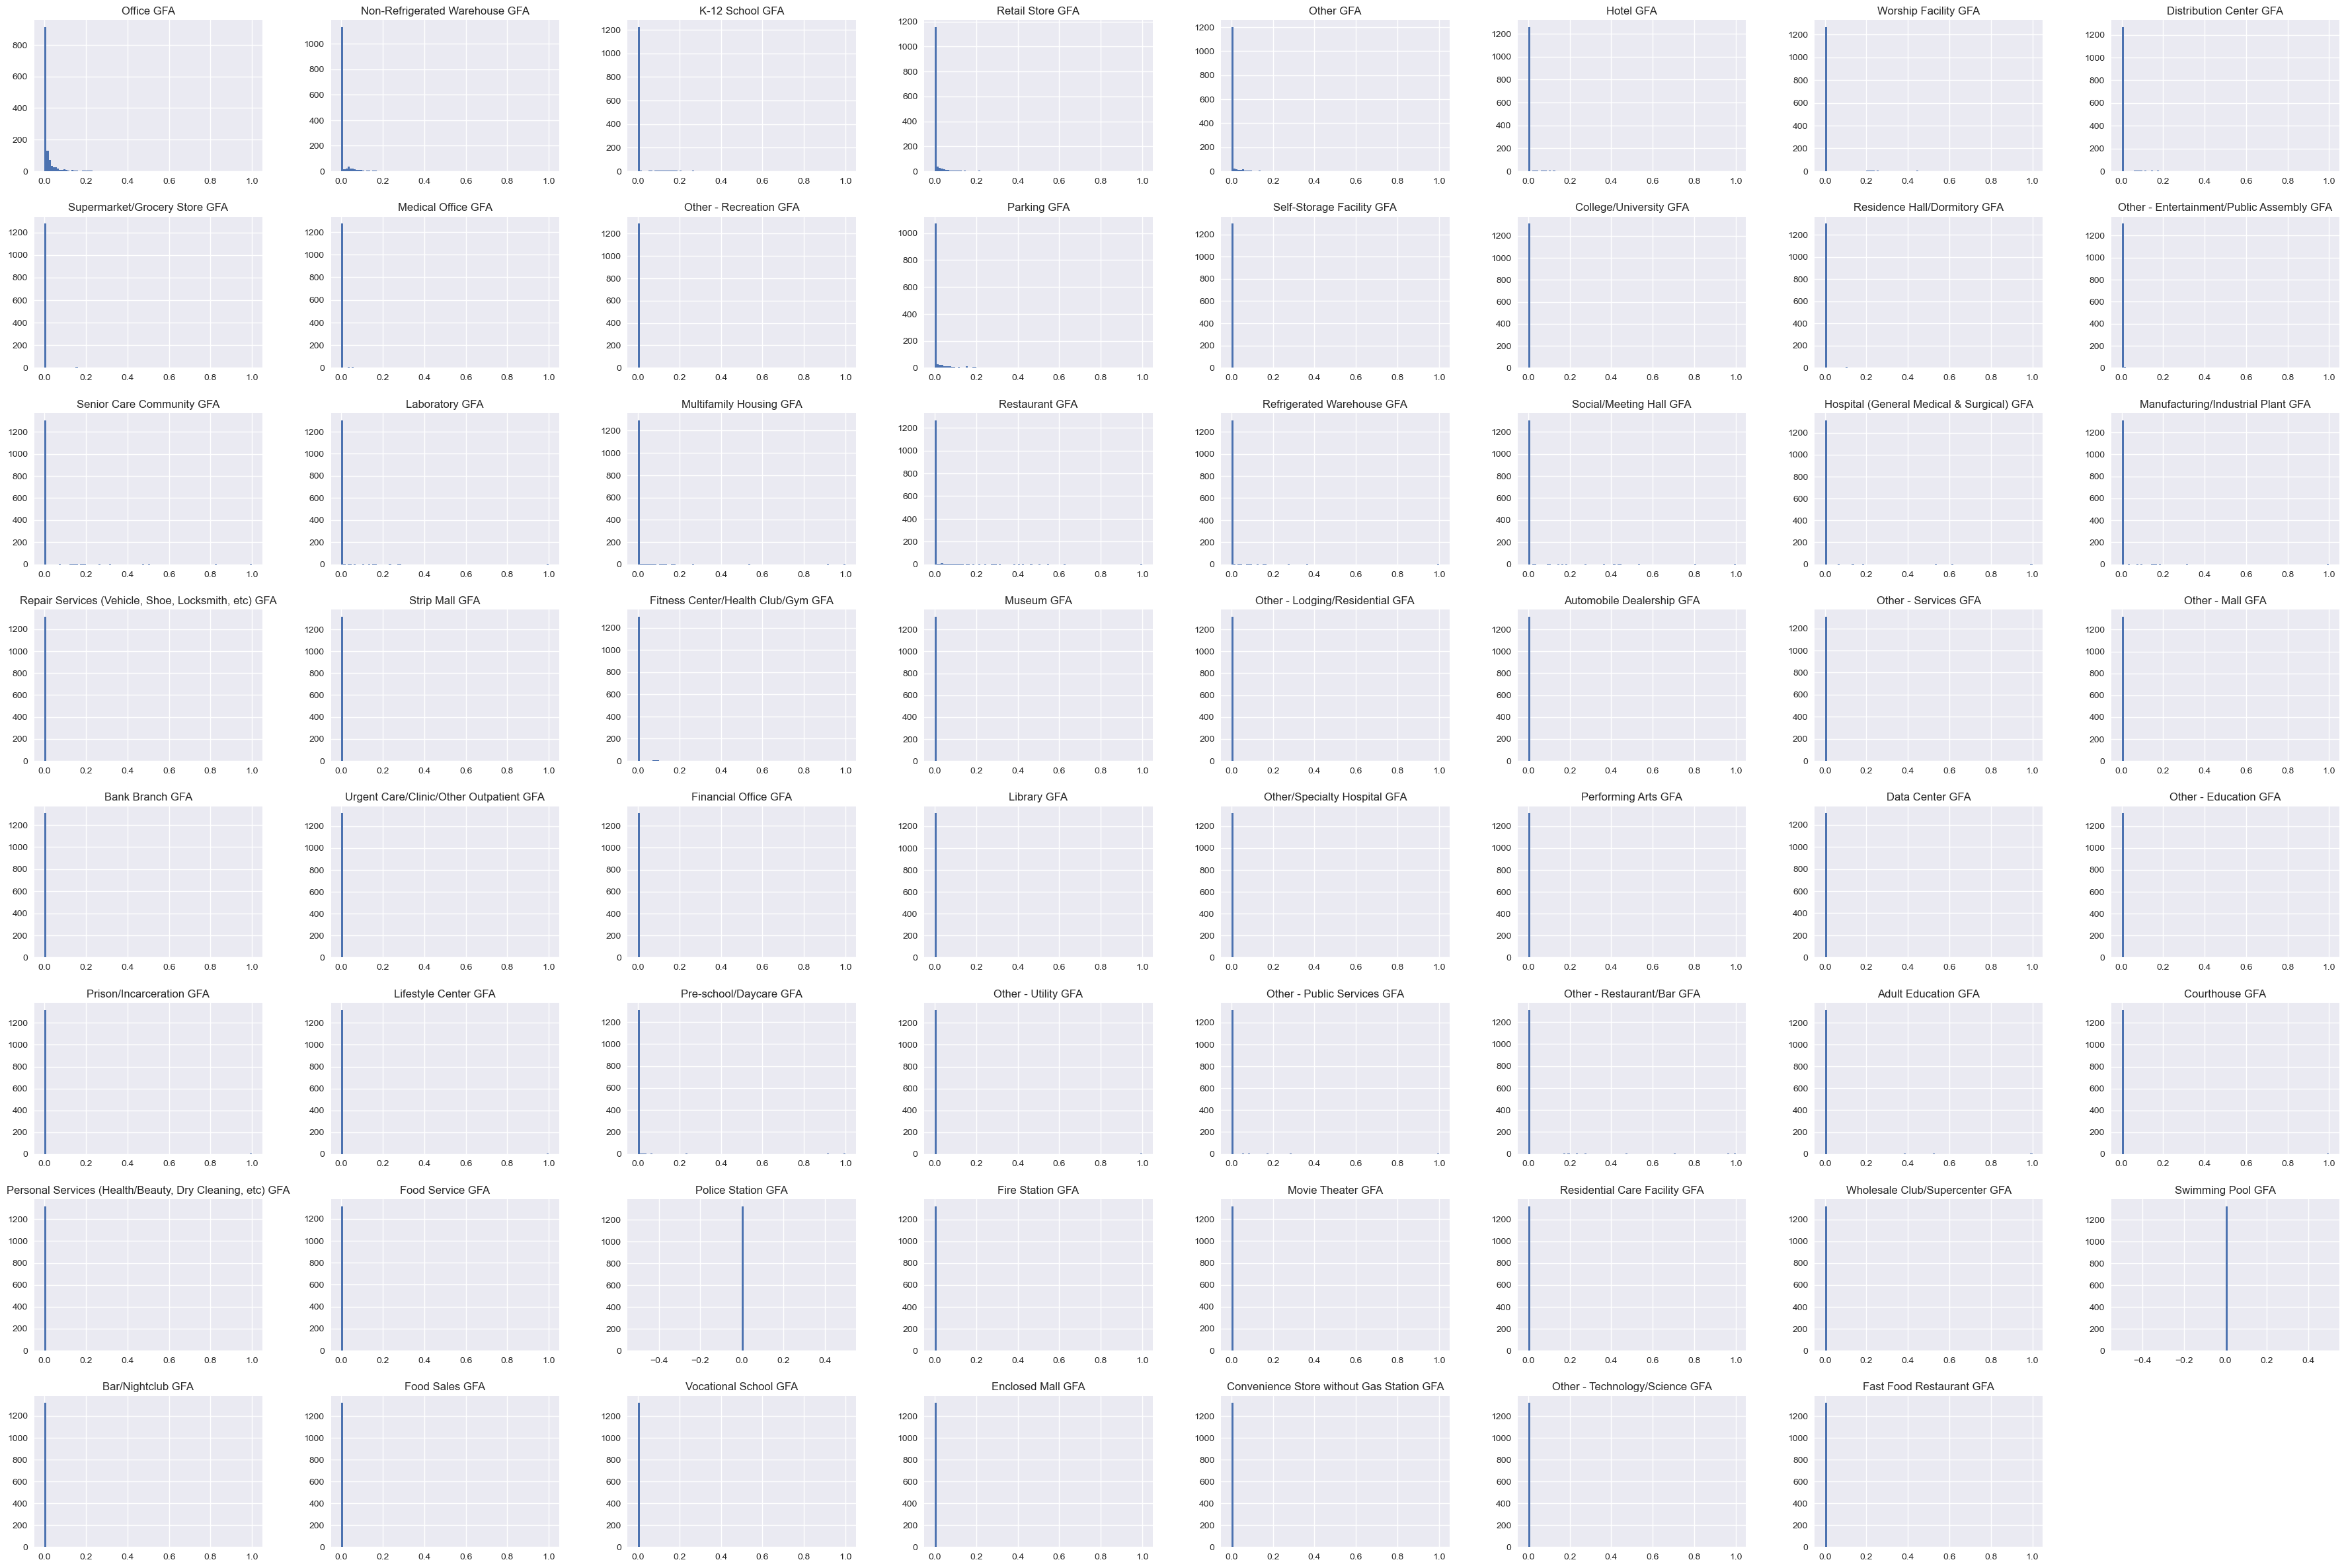

In [86]:
# Tracé des variables quantitatives après recalibrage
df_mms = pd.DataFrame(X_train_EU_mms, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_mms.hist(bins=100, figsize=(45,30))
plt.show()

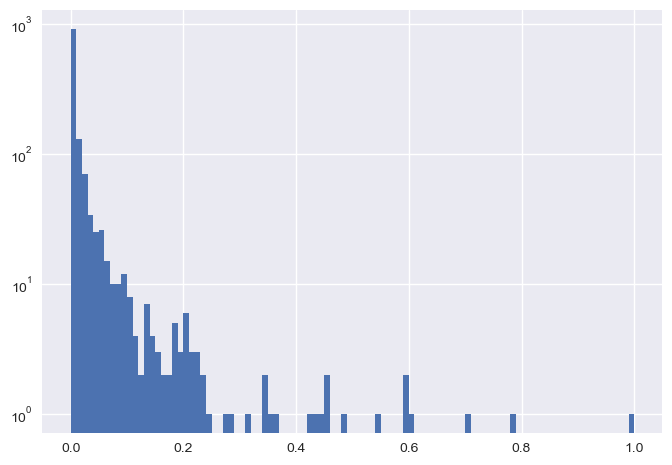

In [87]:
df_mms['Office GFA'].hist(bins=100, log=True);

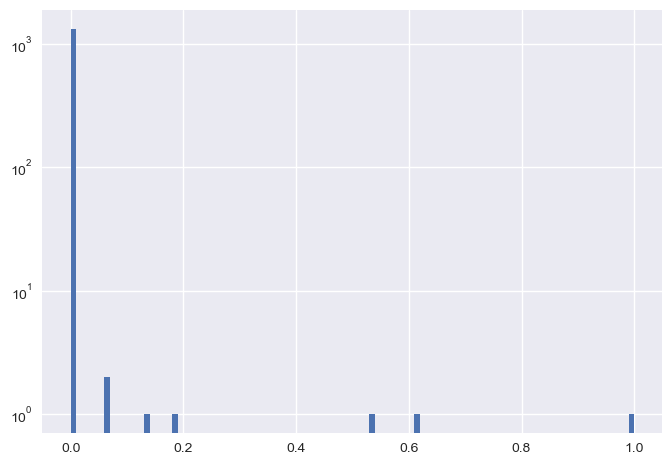

In [88]:
df_mms['Hospital (General Medical & Surgical) GFA'].hist(bins=100, log=True);

##### Régression linéaire simple :

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_mms, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_mms)
print("R² =", arrondi(r2_score(y_train_EU, EU_predictions), 5))

Comme attendu, on retrouve le même R² que pour la régression linéaire simple sans scaler, car le scaler fait une transformation linéaire.

In [ ]:
arrondi(lin_reg.intercept_, puissance10=6)

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU_mms, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU_mms, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Même bug que pour la CV sur MinMaxScaler.

### Conclusion sur le recalibrage des variables

Dans la deuxième approche du problème, le point fort est de tenir compte des superficies spécifiques des types de buisness de chaque propriété.  
En recalibrant les variables avec les scalers classiques, on perd le sens physique des données d'entrée.

## Ridge regression

### Variables non recalibrées

In [ ]:
ridge_nr = RidgeCV(alphas=np.logspace(8, 12, 100), cv=10)    # 100 valeurs alpha entre 1e8 et 1e12
ridge_nr.fit(X_train_EU, y_train_EU)

In [ ]:
best_alpha = ridge_nr.alpha_
arrondi(best_alpha, puissance10=9)

In [ ]:
# R²
R2_nr_ridge_cv = arrondi(ridge_nr.best_score_, 5)
R2_nr_ridge_cv

In [ ]:
arrondi(float(ridge_nr.intercept_), puissance10=6)

In [ ]:
print(ridge_nr.coef_.shape)
ridge_nr.coef_

##### Prédiction sur y_test

In [ ]:
ridge_nr = Ridge(alpha=best_alpha)
ridge_nr.fit(X_train_EU, y_train_EU)
print(arrondi(ridge_nr.score(X_test_EU, y_test_EU), 5))

### Recalibrage par StandardScaler

#### RidgeCV classique (cv=10)

In [ ]:
ridge_ss = RidgeCV(alphas=np.logspace(0, 2, 100), cv=10)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_ss.fit(X_train_EU_ss, y_train_EU)

In [ ]:
best_alpha = ridge_ss.alpha_
best_alpha

In [ ]:
# R²
R2_ss_ridge_cv = arrondi(ridge_ss.best_score_, 5)
R2_ss_ridge_cv

In [ ]:
arrondi(float(ridge_ss.intercept_), puissance10=6)

In [ ]:
print(ridge_ss.coef_.shape)
ridge_ss.coef_

In [ ]:
df_coefs['Coef SS Ridge'] = ridge_ss.coef_.T

In [ ]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Ridge', ascending=False))

In [ ]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Ridge', ascending=True).loc[:, 'Coef SS Ridge'], effectif_array=df_coefs.sort_values(by='Coef SS Ridge', ascending=True).iloc[:, 0])

##### Prédiction sur y_test

In [ ]:
ridge_ss = Ridge(alpha=best_alpha)
ridge_ss.fit(X_train_EU_ss, y_train_EU)
print(arrondi(ridge_ss.score(X_test_EU_ss, y_test_EU), 5))

#### RidgeCV LOO (cv=None (use the Leave-One-Out cross-validation))

In [ ]:
ridge_ss_LOO = RidgeCV(alphas=np.logspace(0, 2, 100), cv=None)
ridge_ss_LOO.fit(X_train_EU_ss, y_train_EU);

In [ ]:
best_alpha = ridge_ss_LOO.alpha_
best_alpha

In [ ]:
# root mean squared error 
R2_ss_ridge_cv_LOO = arrondi(-ridge_ss_LOO.best_score_, 5)   # lorsque cv=None, best_score_ retourne negMSE
print("RMSE =", arrondi(np.sqrt(R2_ss_ridge_cv_LOO), puissance10=6))

C'est mauvais en apparence (RMSE < 10e6 pour des modèles précédents), mais je n'ai pas de LOO pour comparer toutes choses égales par ailleurs.

##### Prédiction sur y_test

In [ ]:
ridge_ss_LOO = Ridge(alpha=best_alpha)
ridge_ss_LOO.fit(X_train_EU_ss, y_train_EU)
print(arrondi(ridge_ss_LOO.score(X_test_EU_ss, y_test_EU), 5))

#### Faire une validation croisée "à la main" pour mieux maitriser le fonctionnement interne d'une fonction "tout-en-un" comme RidgeCV :

In [ ]:
ridge_ss_test = Ridge(alpha=10.235310218990262) 
scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                         scoring="r2", cv=10)
display_scores(scores, 5)

La moyenne des 10 scores pour R² (0.68021 pour l'instance ridge_ss_test) correspond bien au "best score" retourné par la méthode RidgeCV avec le même alpha.  
L'écart-type plutôt élevé est préoccupant ; il traduit un problème lié aux folds.  
Deux hypothèses :  
- types de PropertyUsageType mal répartis entre train et test sets de la CV.  
- propriétés à 'SiteEnergyUse(kBtu)' élevé mal stratifié.

#### Plot du R² en fonction du nb de folds

In [111]:
liste_cv = []
liste_mean = []
liste_std = []
for i in range(2, 80):
    ridge_ss_test = Ridge(alpha=10.235310218990262) 
    scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=i)
    liste_cv.append(i)
    liste_mean.append(scores.mean())
    liste_std.append(scores.std(ddof=1))

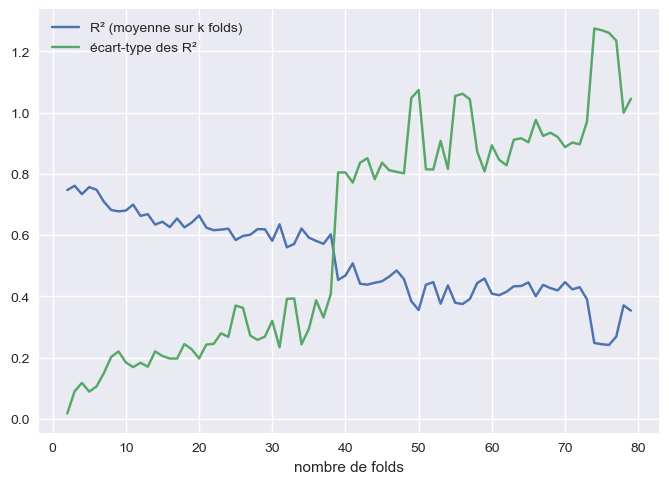

In [112]:
plt.plot(liste_cv, liste_mean)
plt.plot(liste_cv, liste_std)
plt.xlabel('nombre de folds')
plt.legend(['R² (moyenne sur k folds)', 'écart-type des R²']);

La taille du dataset est trop petite pour envisager un nombre de folds trop important.  

#### Plot du R² en fonction de alpha

In [ ]:
# calcul de la baseline_R2
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
baseline_R2 = lin_scores.mean()
baseline_R2

In [70]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(-1, 2, 100)   # 100 valeurs alpha entre 1e-1 et 1e2
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    ridge_ss_test = Ridge(alpha=alpha) 
    scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=10)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

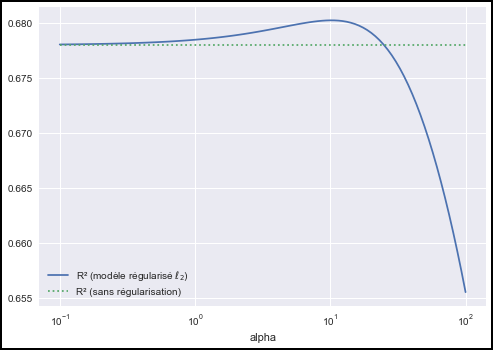

In [71]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_2$'+')', 'R² (sans régularisation)']);

Le gain obtenu pour le modèle régularisé par rapport au modèle linéaire simple est très faible.  
L'optimum se situe vers alpha = 10.  

### Recalibrage par MinMaxScaler

In [ ]:
ridge_mms = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=10)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_mms.fit(X_train_EU_mms, y_train_EU)

In [ ]:
best_alpha = ridge_mms.alpha_
best_alpha

In [ ]:
# R²
R2_mms_ridge_cv = arrondi(ridge_mms.best_score_)
R2_mms_ridge_cv

In [ ]:
arrondi(float(ridge_mms.intercept_), puissance10=6)

In [ ]:
print(ridge_ss.coef_.shape)
display(ridge_mms.coef_)

Conclusion sur MinMaxScaler vs StandardScaler : le R² n'a pas été amélioré.  

##### Prédiction sur y_test

In [ ]:
ridge_mms = Ridge(alpha=best_alpha)
ridge_mms.fit(X_train_EU_mms, y_train_EU)
print(arrondi(ridge_mms.score(X_test_EU_mms, y_test_EU), 5))

### Conclusion sur les régressions ridge

Le gain de R² obtenu par l'ajout d'un régularisateur ridge est faible :  
- R² = {{R2_nr_ridge_cv}} sans recalibrage.  
- R² = {{R2_ss_ridge_cv}} si recalibrage StandardScaler.
- R² = {{R2_mms_ridge_cv}} si recalibrage MinMaxScaler.
En particulier car les variables sont très rarement corrélées entre elles (cf conclusion concernant la heatmap).

## Régression LASSO (variables recalibrées par StandardScaler)

### Fonction LassoCV

In [ ]:
lasso_ss = LassoCV(alphas=np.logspace(1, 6, 100), cv=10, tol=1e-10) 
lasso_ss.fit(X_train_EU_ss, y_train_EU.iloc[:,0])

In [ ]:
lasso_ss.alpha_

In [ ]:
lasso_ss.n_iter_

In [ ]:
arrondi(lasso_ss.intercept_, puissance10=6)

Malgré le paramètre tol très faible, je ne parviens pas à avoir un calcul de LassoCV qui termine sur les valeurs obtenues avec la fonction Lasso.

### Plot du R² en fonction de alpha (fonction Lasso)

In [84]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(2, 5.3, 300)   # 300 valeurs alpha
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha) 
    scores = cross_val_score(lasso_ss, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=10)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

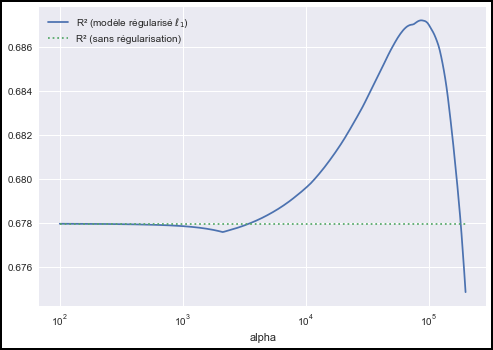

In [85]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [86]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
print("Valeur optimale de R² =", arrondi(liste_R2[indice_du_maxi]))

Valeur optimale de alpha = 86255.33240735748
Valeur optimale de R² = 0.687


In [87]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_EU_ss, y_train_EU)

Lasso(alpha=86255.33240735748)

In [88]:
arrondi(float(lasso_optimum.intercept_), puissance10=6)

'8.41e6'

In [89]:
lasso_optimum.coef_

array([ 6.65293686e+06,  1.75931605e+06,  9.75909061e+05,  8.26976357e+05,  3.77873676e+06,  4.31739982e+06,  1.80934886e+05,  3.01365917e+05,  1.42573110e+06,
        2.54920803e+06,  1.01901692e+06, -1.60679937e+05,  0.00000000e+00,  2.42788386e+07,  4.07729217e+05,  1.71481486e+06,  1.37958832e+06,  1.02230054e+07,
        3.06038929e+05,  9.18442516e+05,  7.14612625e+05,  3.78374846e+05,  1.14118354e+07,  1.07180707e+05,  1.16073797e+05,  5.54284299e+05,  1.57564923e+05,
        5.32861782e+05,  0.00000000e+00,  2.65024108e+05,  8.83271750e+04,  0.00000000e+00,  0.00000000e+00,  5.95003936e+05,  1.73363748e+06,  1.04157458e+06,
        1.58759362e+05,  3.51988217e+04,  2.93246834e+04,  2.64694013e+06,  0.00000000e+00,  0.00000000e+00,  3.91990642e+05,  6.08814968e+04,  5.70784517e+05,
        0.00000000e+00,  1.10660168e+05,  0.00000000e+00,  2.79579728e+05,  1.86884922e+04, -0.00000000e+00,  0.00000000e+00,  8.62135172e+04,  0.00000000e+00,
        8.01122058e+04,  0.00000000e+00,

Le lasso met un grand nombre de coefficients à 0.

In [90]:
df_coefs['Coef SS Lasso'] = lasso_optimum.coef_.T

In [91]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Lasso', ascending=False))

,Effectif,Coef NR LR,Coef SS LR,Coef SS Lasso
College/University,25,9.3e+01,2.4e+07,2.4e+07
Hospital (General Medical & Surgical),11,2.0e+02,1.2e+07,1.1e+07
Laboratory,23,4.8e+02,1.0e+07,1.0e+07
Office,712,5.9e+01,7.2e+06,6.7e+06
Hotel,80,9.1e+01,4.5e+06,4.3e+06
Other,181,1.2e+02,3.9e+06,3.8e+06
Data Center,30,7.8e+02,2.8e+06,2.6e+06
Medical Office,58,1.1e+02,2.8e+06,2.5e+06
Non-Refrigerated Warehouse,244,5.9e+01,1.9e+06,1.8e+06
Urgent Care/Clinic/Other Outpatient,4,3.8e+02,1.8e+06,1.7e+06


In [ ]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Lasso', ascending=True).loc[:, 'Coef SS Lasso'], effectif_array=df_coefs.sort_values(by='Coef SS Lasso', ascending=True).iloc[:, 0])

Le gain de R² obtenu par l'ajout d'un régularisateur ridge est faible.  
Toutes choses égales par ailleurs (scaling SS, CV=10 dans les modèles), les R² sont :
- 0.678 (sans régularisation),  
- 0.679 (Ridge),
- 0.687 (Lasso).

##### Prédiction sur y_test

In [92]:
lasso_optimum.fit(X_train_EU_ss, y_train_EU)
print(arrondi(lasso_optimum.score(X_test_EU_ss, y_test_EU), 5))

0.83434


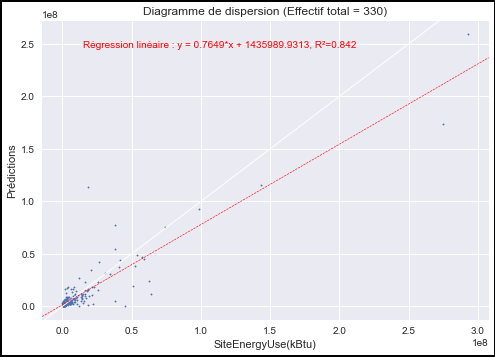

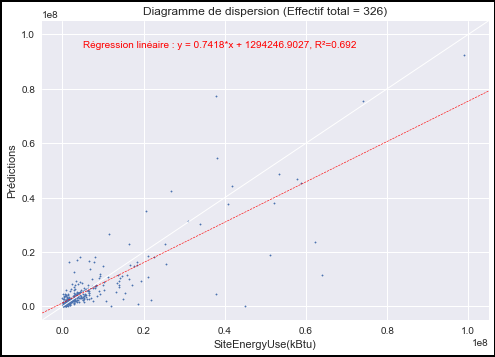

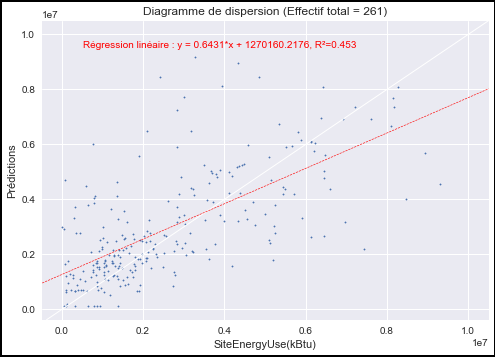

In [93]:
EU_predictions = lasso_optimum.predict(X_test_EU_ss)
ser_predictions = pd.Series(np.squeeze(EU_predictions), name='Prédictions')
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e7, max_y=1e7, ligne_diagonale=True)

## Arbres de décision (DecisionTreeRegressor)

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_EU, y_train_EU)

In [ ]:
df_feature_importances = pd.Series(tree_reg.feature_importances_, index=liste_modalites_types_1_2_3)
df_feature_importances.sort_values(ascending=False).head(100)

##### RMSE / validation croisée

In [ ]:
scores = cross_val_score(tree_reg, X_train_EU, y_train_EU, 
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, puissance10=6)

##### R² / validation croisée

In [ ]:
scores = cross_val_score(tree_reg, X_train_EU, y_train_EU, 
                         scoring="r2", cv=10)
display_scores(scores)

On passe de R²=-0.16 (validation croisée sur le X_train_EUI_prepared de la première approche du problème à 241 variables), à R² = 0.37.

##### Dessin de l'arbre

In [ ]:
export_graphviz(
        tree_reg,
        out_file="tree_reg.dot",
        feature_names=liste_modalites_types_1_2_3,
        class_names="SiteEnergyUse(kBtu)",
        rounded=True,
        filled=True
    )

In [ ]:
# Source.from_file("tree_reg.dot")

In [ ]:
tree_reg.get_n_leaves()

In [ ]:
tree_reg.get_depth()

### Régularisation

In [ ]:
param_grid = [{'max_depth': [2, 4, 8, 16, 32, 64, 128, 256], 'random_state': [0]}, {'min_samples_leaf': [2**x for x in range(12)]}]
grid_search = GridSearchCV(tree_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

Le meilleur R² est mauvais.

##### Généralisation sur le test set

In [ ]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", r2_score(y_test_EU, EU_predictions))

De manière surprenante, le R² du test set est bon.

## Forêts aléatoires

In [ ]:
forest_reg = RandomForestRegressor(random_state=0)
# forest_reg = RandomForestRegressor(n_estimators=20, max_features=20, random_state=0)
forest_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

In [ ]:
forest_scores = cross_val_score(forest_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
display_scores(-forest_scores, puissance10=6)

In [ ]:
forest_scores = cross_val_score(forest_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="r2", cv=10, n_jobs=-1)
display_scores(forest_scores)

##### Généralisation sur le test set

In [ ]:
EU_predictions = forest_reg.predict(X_test_EU)
print("R² =", r2_score(y_test_EU, EU_predictions))

C'est encourageant pour mener une optimisation des paramètres / régularisation.

### Régularisation

##### GridSearchCV à une dimension :

In [110]:
param_grid = [{'max_depth': [4, 8, 16, 32, 64, 128]}, 
    {'min_samples_leaf': [2**x for x in range(9)]},
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}]
grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:, 0])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [4, 8, 16, 32, 64, 128]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128,
                                               256]},
                         {'max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}],
             return_train_score=True, scoring='r2')

In [111]:
grid_search.best_params_

{'n_estimators': 128}

In [112]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=128, random_state=0)

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.216 {'max_depth': 4}
R² =    0.364 {'max_depth': 8}
R² =    0.451 {'max_depth': 16}
R² =    0.476 {'max_depth': 32}
R² =    0.477 {'max_depth': 64}
R² =    0.477 {'max_depth': 128}
R² =    0.477 {'min_samples_leaf': 1}
R² =     0.41 {'min_samples_leaf': 2}
R² =   0.0284 {'min_samples_leaf': 4}
R² =  -0.0576 {'min_samples_leaf': 8}
R² =    0.162 {'min_samples_leaf': 16}
R² =    0.142 {'min_samples_leaf': 32}
R² =    0.122 {'min_samples_leaf': 64}
R² =   0.0521 {'min_samples_leaf': 128}
R² =  -0.0297 {'min_samples_leaf': 256}
R² =    0.417 {'max_features': 4}
R² =     0.46 {'max_features': 8}
R² =    0.451 {'max_features': 16}
R² =    0.437 {'max_features': 32}
R² =    0.477 {'max_features': 63}
R² =    0.445 {'n_estimators': 4}
R² =    0.451 {'n_estimators': 8}
R² =    0.462 {'n_estimators': 16}
R² =    0.465 {'n_estimators': 32}
R² =    0.476 {'n_estimators': 64}
R² =    0.477 {'n_estimators': 128}
R² =    0.476 {'n_estimators': 256}


Les R² sont faibles.  

##### GridSearchCV à deux dimensions :

In [114]:
param_grid = [{'max_depth': [4, 16, 64], 'min_samples_leaf': [1, 2], 'max_features': [16, 32, 63], 'n_estimators': [4, 16, 64, 256]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [4, 16, 64],
                          'max_features': [16, 32, 63],
                          'min_samples_leaf': [1, 2],
                          'n_estimators': [4, 16, 64, 256]}],
             return_train_score=True, scoring='r2')

In [115]:
grid_search.best_params_

{'max_depth': 64,
 'max_features': 63,
 'min_samples_leaf': 1,
 'n_estimators': 256}

In [116]:
grid_search.best_score_

0.47623248079314956

In [117]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² = 0.000737 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 4}
R² =    0.199 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.172 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 64}
R² =    0.198 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 256}
R² =    0.183 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 2, 'n_estimators': 4}
R² =     0.26 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 2, 'n_estimators': 16}
R² =    0.281 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 2, 'n_estimators': 64}
R² =    0.315 {'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 2, 'n_estimators': 256}
R² =    0.216 {'max_depth': 4, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 4}
R² =    0.228 {'max_depth': 4, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.202 {'max_depth': 4, 'max_features': 32, 'min_sampl

##### Généralisation sur le test set

In [118]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.612


Le score est à peine meilleur que celui d'un arbre de décision (0.59 vs 0.62).

## AdaBoost DecisionTreeRegressor

In [ ]:
ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=None), n_estimators=50,
    learning_rate=1.0, random_state=0)
ada_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

In [ ]:
ada_scores = cross_val_score(ada_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="r2", cv=10, n_jobs=-1)
display_scores(ada_scores)

C'est encourageant.

### Régularisation

##### GridSearchCV à une dimension :

In [121]:
ada_reg.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 0}

In [122]:
param_grid = [{'base_estimator__max_depth': [4, 8, 16, 32, 64, 128]}, 
    {'base_estimator__min_samples_leaf': [2**x for x in range(9)]},
    {'base_estimator__max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}]
grid_search = GridSearchCV(ada_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:, 0])

GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=0),
             n_jobs=-1,
             param_grid=[{'base_estimator__max_depth': [4, 8, 16, 32, 64, 128]},
                         {'base_estimator__min_samples_leaf': [1, 2, 4, 8, 16,
                                                               32, 64, 128,
                                                               256]},
                         {'base_estimator__max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}],
             return_train_score=True, scoring='r2')

In [123]:
grid_search.best_params_

{'n_estimators': 128}

In [124]:
arrondi(grid_search.best_score_)

0.504

In [125]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    -1.02 {'base_estimator__max_depth': 4}
R² =   -0.601 {'base_estimator__max_depth': 8}
R² =     0.41 {'base_estimator__max_depth': 16}
R² =    0.458 {'base_estimator__max_depth': 32}
R² =    0.488 {'base_estimator__max_depth': 64}
R² =    0.501 {'base_estimator__max_depth': 128}
R² =    0.501 {'base_estimator__min_samples_leaf': 1}
R² =    0.491 {'base_estimator__min_samples_leaf': 2}
R² =      0.5 {'base_estimator__min_samples_leaf': 4}
R² =    0.475 {'base_estimator__min_samples_leaf': 8}
R² =    0.401 {'base_estimator__min_samples_leaf': 16}
R² =  -0.0624 {'base_estimator__min_samples_leaf': 32}
R² =    -1.67 {'base_estimator__min_samples_leaf': 64}
R² =    -2.88 {'base_estimator__min_samples_leaf': 128}
R² =     -1.4 {'base_estimator__min_samples_leaf': 256}
R² =    0.397 {'base_estimator__max_features': 4}
R² =    0.411 {'base_estimator__max_features': 8}
R² =    0.464 {'base_estimator__max_features': 16}
R² =    0.487 {'base_estimator__max_features': 32}
R² =    0.501 {'ba

##### GridSearchCV à deux dimensions :

In [126]:
param_grid = [{'base_estimator__max_depth': [8, 32, 128], 'base_estimator__min_samples_leaf': [1, 2], 'base_estimator__max_features': [16, 32, 63], 'n_estimators': [8, 32, 50, 64, 128]}]

grid_search = GridSearchCV(ada_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=0),
             n_jobs=-1,
             param_grid=[{'base_estimator__max_depth': [8, 32, 128],
                          'base_estimator__max_features': [16, 32, 63],
                          'base_estimator__min_samples_leaf': [1, 2],
                          'n_estimators': [8, 32, 50, 64, 128]}],
             return_train_score=True, scoring='r2')

In [127]:
grid_search.best_params_

{'base_estimator__max_depth': 128,
 'base_estimator__max_features': 63,
 'base_estimator__min_samples_leaf': 2,
 'n_estimators': 128}

In [128]:
arrondi(grid_search.best_score_)

0.508

In [129]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.235 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 8}
R² =  -0.0857 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 32}
R² =   -0.329 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 50}
R² =   -0.344 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 64}
R² =   -0.378 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.205 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 2, 'n_estimators': 8}
R² =   -0.355 {'base_estimator__max_depth': 8, 'base_estimator__max_features': 16, 'base_estimator__min_samples_leaf': 2, 'n_estimators': 32}
R² =   

La régularisation n'a rien apporté ; les paramètres optimum pour les arbres sont en butée : max_depth au max, max_features au max, min_samples_leaf à 1.

##### Généralisation sur le test set

In [130]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.626


Le score est à peine meilleur que celui d'un arbre de décision (0.59) ou qu'une random_forest (0.62).

## Gradient boosted regression trees

Note : c'est l'équivalent sklearn de XGBoost.

In [ ]:
GBT_reg = GradientBoostingRegressor(random_state=0)
GBT_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

In [ ]:
GBT_scores = cross_val_score(GBT_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="r2", cv=10, n_jobs=-1)
display_scores(GBT_scores)

C'est aussi bien que le régresseur par défaut avec AdaBoost.

### Régularisation

##### GridSearchCV à une dimension :

In [ ]:
GBT_reg.get_params()

In [ ]:
param_grid = [{'max_depth': [1, 2, 3, 4, 8, 16, 32, 64, 128]}, 
    {'min_samples_leaf': [2**x for x in range(9)]},
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64, 128, 256, 512]}]
grid_search = GridSearchCV(GBT_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:, 0])

In [ ]:
grid_search.best_params_

In [ ]:
arrondi(grid_search.best_score_)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

##### GridSearchCV à deux dimensions :

In [396]:
param_grid = [{'min_samples_leaf': [1], 'max_depth': [1, 2, 3, 4, 5], 'max_features': [16, 32, 63], 'n_estimators': [128, 512]}]  # temps de calcul fortement lié à n_estimators

grid_search = GridSearchCV(GBT_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=7,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5],
                          'max_features': [16, 32, 63], 'min_samples_leaf': [1],
                          'n_estimators': [128, 512]}],
             return_train_score=True, scoring='r2')

In [397]:
grid_search.best_params_

{'max_depth': 2,
 'max_features': 63,
 'min_samples_leaf': 1,
 'n_estimators': 512}

In [398]:
arrondi(grid_search.best_score_)

0.566

In [399]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.381 {'max_depth': 1, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.541 {'max_depth': 1, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =     0.39 {'max_depth': 1, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.539 {'max_depth': 1, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =     0.39 {'max_depth': 1, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.538 {'max_depth': 1, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.476 {'max_depth': 2, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.545 {'max_depth': 2, 'max_features': 16, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.473 {'max_depth': 2, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.543 {'max_depth': 2, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.497 {'max_depth': 2, 'max_features': 63,

On pousse sur n_estimators :

In [138]:
param_grid = [{'min_samples_leaf': [1], 'max_depth': [2, 3], 'max_features': [63], 'n_estimators': [1024, 2048]}]  # temps de calcul fortement lié à n_estimators

grid_search = GridSearchCV(GBT_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid=[{'max_depth': [2, 3], 'max_features': [63],
                          'min_samples_leaf': [1],
                          'n_estimators': [1024, 2048]}],
             return_train_score=True, scoring='r2')

In [139]:
grid_search.best_params_

{'max_depth': 2,
 'max_features': 63,
 'min_samples_leaf': 1,
 'n_estimators': 1024}

In [140]:
arrondi(grid_search.best_score_)

0.566

In [141]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.566 {'max_depth': 2, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 1024}
R² =    0.564 {'max_depth': 2, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 2048}
R² =    0.561 {'max_depth': 3, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 1024}
R² =    0.555 {'max_depth': 3, 'max_features': 63, 'min_samples_leaf': 1, 'n_estimators': 2048}


##### Généralisation sur le test set

In [142]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.626


Résumé des meilleurs scores obtenus pour les modèles basés sur des DecisionTreeRegressor après généralisation sur le test set :
- arbre de décision simple (0.59).  
- random forest (0.62).  
- AdaBoost (0.63).
- Gradient Boosted (0.62).

## Bagging de modèle linéaire

In [152]:
bag_reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, n_jobs=-1, random_state=0, verbose=1)
bag_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


BaggingRegressor(base_estimator=LinearRegression(), n_jobs=-1, random_state=0,
                 verbose=1)

In [153]:
bag_scores = cross_val_score(bag_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="r2", cv=10, n_jobs=-1)
display_scores(bag_scores)

Scores: 0.91 0.474 0.861 0.717 0.866 0.756 0.97 0.613 0.666 0.614 
Mean: 0.745
Standard deviation: 0.157


On passe de R²=0.68 (validation croisée sans bagging) à R²=0.74 (validation croisée avec bagging).

### Régularisation régression linéaire simple

##### GridSearchCV à une dimension :

In [229]:
bag_reg = BaggingRegressor(base_estimator=LinearRegression(), n_jobs=-1, random_state=0)
param_grid = [
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'bootstrap': [True, False]},
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:, 0])

GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=LinearRegression(),
                                        n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid=[{'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'bootstrap': [True, False]},
                         {'max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [230]:
grid_search.best_params_

{'max_samples': 0.5}

In [232]:
arrondi(grid_search.best_score_)

0.756

In [233]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.705 {'max_samples': 0.25}
R² =    0.756 {'max_samples': 0.5}
R² =    0.747 {'max_samples': 0.75}
R² =    0.745 {'max_samples': 1.0}
R² =    0.745 {'bootstrap': True}
R² =    0.678 {'bootstrap': False}
R² =   0.0978 {'max_features': 4}
R² =    0.145 {'max_features': 8}
R² =    0.338 {'max_features': 16}
R² = -25400000000000.0 {'max_features': 32}
R² =    0.745 {'max_features': 63}
R² =    0.723 {'n_estimators': 4}
R² =    0.743 {'n_estimators': 8}
R² =    0.743 {'n_estimators': 16}
R² =    0.727 {'n_estimators': 32}
R² =    0.723 {'n_estimators': 64}


##### GridSearchCV à deux dimensions :

In [234]:
param_grid = [
    {'max_samples': [0.25, 0.5, 0.75, 1.0], 
    'bootstrap': [True, False],
    'max_features': [16, 32, 63],
    'n_estimators': [4, 8, 16, 32]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=LinearRegression(),
                                        n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [16, 32, 63],
                          'max_samples': [0.25, 0.5, 0.75, 1.0],
                          'n_estimators': [4, 8, 16, 32]}],
             return_train_score=True, scoring='r2')

In [235]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}

In [236]:
arrondi(grid_search.best_score_)

0.755

In [237]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.169 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.25, 'n_estimators': 4}
R² =    0.197 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.25, 'n_estimators': 8}
R² =    0.294 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.25, 'n_estimators': 16}
R² =    0.303 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.25, 'n_estimators': 32}
R² =     0.17 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.5, 'n_estimators': 4}
R² =    0.231 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.352 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.339 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.5, 'n_estimators': 32}
R² =    0.171 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.75, 'n_estimators': 4}
R² =    0.254 {'bootstrap': True, 'max_features': 16, 'max_samples': 0.75, 'n_estimators': 8}
R² =    0.367 {'bootstrap': True, 'max_features': 16, 'max_s

La régularisation a apporté un léger gain de R².

##### Généralisation sur le test set

In [238]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.874


Le R² est meilleur que ceux obtenus jusqu'ici.

##### Scatter plot

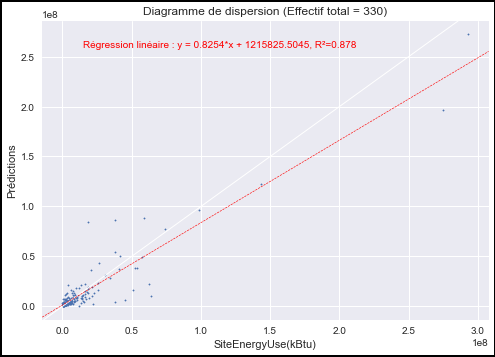

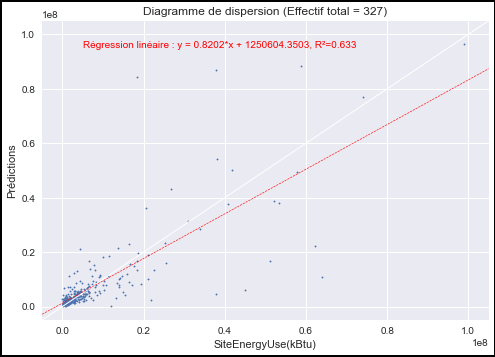

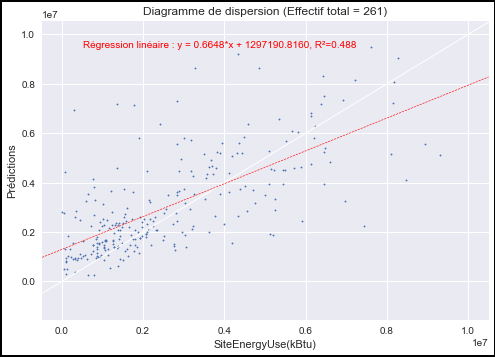

In [239]:
ser_predictions = pd.Series(np.squeeze(EU_predictions), name='Prédictions')
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)
scatter_plot(ser_x=y_test_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e7, min_y = -0.1e7, max_y=1e7, ligne_diagonale=True)

### Régularisation régression Ridge

##### GridSearchCV à une dimension :

In [179]:
bag_reg = BaggingRegressor(base_estimator=Ridge(alpha=2e9), max_samples=0.5, n_jobs=-1, random_state=0)
param_grid = [
    {'base_estimator__alpha': np.logspace(8, 12, 10)}, 
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:, 0])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=2000000000.0),
                                        max_samples=0.5, n_jobs=-1,
                                        random_state=0, verbose=1),
             n_jobs=-1,
             param_grid=[{'base_estimator__alpha': array([1.00000000e+08, 2.78255940e+08, 7.74263683e+08, 2.15443469e+09, 5.99484250e+09, 1.66810054e+10, 4.64158883e+10, 1.29154967e+11, 3.59381366e+11,
       1.00000000e+12])},
                         {'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [180]:
grid_search.best_params_

{'n_estimators': 16}

In [181]:
arrondi(grid_search.best_score_)

0.776

In [182]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =     0.77 {'base_estimator__alpha': 100000000.0}
R² =    0.772 {'base_estimator__alpha': 278255940.2207126}
R² =    0.774 {'base_estimator__alpha': 774263682.6811278}
R² =    0.771 {'base_estimator__alpha': 2154434690.0318866}
R² =    0.756 {'base_estimator__alpha': 5994842503.189421}
R² =    0.725 {'base_estimator__alpha': 16681005372.000557}
R² =    0.682 {'base_estimator__alpha': 46415888336.12772}
R² =    0.627 {'base_estimator__alpha': 129154966501.48827}
R² =    0.558 {'base_estimator__alpha': 359381366380.4626}
R² =    0.468 {'base_estimator__alpha': 1000000000000.0}
R² =    0.733 {'max_samples': 0.25}
R² =    0.772 {'max_samples': 0.5}
R² =    0.771 {'max_samples': 0.75}
R² =    0.758 {'max_samples': 1.0}
R² =   0.0806 {'max_features': 4}
R² =    0.135 {'max_features': 8}
R² =    0.308 {'max_features': 16}
R² =    0.531 {'max_features': 32}
R² =    0.772 {'max_features': 63}
R² =    0.755 {'n_estimators': 4}
R² =     0.77 {'n_estimators': 8}
R² =    0.776 {'n_estimators': 1

##### GridSearchCV à deux dimensions :

In [184]:
param_grid = [
    {'base_estimator__alpha': np.logspace(8, 10, 10),
    'max_samples': [0.25, 0.5, 0.75, 1.0], 
    'max_features': [16, 32, 48, 56, 63],
    'n_estimators': [4, 8, 16, 32]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=2000000000.0),
                                        max_samples=0.5, n_jobs=-1,
                                        random_state=0, verbose=1),
             n_jobs=-1,
             param_grid=[{'base_estimator__alpha': array([1.00000000e+08, 1.66810054e+08, 2.78255940e+08, 4.64158883e+08, 7.74263683e+08, 1.29154967e+09, 2.15443469e+09, 3.59381366e+09, 5.99484250e+09,
       1.00000000e+10]),
                          'max_features': [16, 32, 48, 56, 63],
                          'max_samples': [0.25, 0.5, 0.75, 1.0],
                          'n_estimators': [4, 8, 16, 32]}],
             return_train_score=True, scoring='r2')

In [185]:
grid_search.best_params_

{'base_estimator__alpha': 774263682.6811278,
 'max_features': 63,
 'max_samples': 0.5,
 'n_estimators': 16}

In [186]:
arrondi(grid_search.best_score_)

0.78

In [198]:
cvres = grid_search.cv_results_
resultats_zip = zip(cvres["mean_test_score"], cvres["params"])
resultats_zip = list(resultats_zip)
resultats_zip.sort(reverse=True)   # tri par score
for mean_score, params in resultats_zip:
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =     0.78 {'base_estimator__alpha': 774263682.6811278, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.779 {'base_estimator__alpha': 464158883.3612773, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.778 {'base_estimator__alpha': 1291549665.0148828, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.778 {'base_estimator__alpha': 278255940.2207126, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.775 {'base_estimator__alpha': 774263682.6811278, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 32}
R² =    0.775 {'base_estimator__alpha': 166810053.72000557, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.775 {'base_estimator__alpha': 2154434690.0318866, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.775 {'base_estimator__alpha': 1291549665.0148828, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 32}
R² =    0.774 {'base_estimator__alpha': 4641

Le Ridge a apporté un léger gain de R² par rapport à la régression linéaire simple.

##### Généralisation sur le test set

In [200]:
EU_predictions = grid_search.predict(X_test_EU)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.832


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


La généralisation du Ridge est moins bonne que pour la régression linéaire simple.

### Régularisation régression Ridge avec data normalisée par StandardScaler

##### GridSearchCV à une dimension :

In [206]:
bag_reg = BaggingRegressor(base_estimator=Ridge(alpha=0.1), max_samples=0.5, n_jobs=-1, random_state=0, verbose=1)
param_grid = [
    {'base_estimator__alpha': np.logspace(-2, 2, 20)}, 
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU_ss, y_train_EU.iloc[:, 0])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=0.1),
                                        max_samples=0.5, n_jobs=-1,
                                        random_state=0, verbose=1),
             n_jobs=-1,
             param_grid=[{'base_estimator__alpha': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02, 6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01, 4.83293024e-01,
       7.84759970e-01, 1.27427499e+00, 2.06913808e+00, 3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01, 2.33572147e+01, 3.79269019e+01,
       6.15848211e+01, 1.00000000e+02])},
                         {'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [207]:
grid_search.best_params_

{'base_estimator__alpha': 0.4832930238571752}

In [208]:
arrondi(grid_search.best_score_)

0.761

In [209]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.756 {'base_estimator__alpha': 0.01}
R² =    0.757 {'base_estimator__alpha': 0.016237767391887217}
R² =    0.757 {'base_estimator__alpha': 0.026366508987303583}
R² =    0.758 {'base_estimator__alpha': 0.04281332398719394}
R² =    0.758 {'base_estimator__alpha': 0.06951927961775606}
R² =    0.759 {'base_estimator__alpha': 0.11288378916846889}
R² =     0.76 {'base_estimator__alpha': 0.18329807108324356}
R² =    0.761 {'base_estimator__alpha': 0.29763514416313175}
R² =    0.761 {'base_estimator__alpha': 0.4832930238571752}
R² =     0.76 {'base_estimator__alpha': 0.7847599703514611}
R² =    0.757 {'base_estimator__alpha': 1.2742749857031335}
R² =    0.753 {'base_estimator__alpha': 2.06913808111479}
R² =    0.746 {'base_estimator__alpha': 3.359818286283781}
R² =    0.735 {'base_estimator__alpha': 5.455594781168514}
R² =    0.721 {'base_estimator__alpha': 8.858667904100823}
R² =    0.704 {'base_estimator__alpha': 14.38449888287663}
R² =    0.683 {'base_estimator__alpha': 23.35721469

##### GridSearchCV à deux dimensions :

In [210]:
param_grid = [
    {'base_estimator__alpha': np.logspace(-2, 1, 10),
    'max_samples': [0.25, 0.5, 0.75, 1.0], 
    'max_features': [16, 32, 48, 56, 63],
    'n_estimators': [4, 8, 16]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU_ss, y_train_EU.iloc[:,0])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=0.1),
                                        max_samples=0.5, n_jobs=-1,
                                        random_state=0, verbose=1),
             n_jobs=-1,
             param_grid=[{'base_estimator__alpha': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,  0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                          'max_features': [16, 32, 48, 56, 63],
                          'max_samples': [0.25, 0.5, 0.75, 1.0],
                          'n_estimators': [4, 8, 16]}],
             return_train_score=True, scoring='r2')

In [211]:
grid_search.best_params_

{'base_estimator__alpha': 0.46415888336127775,
 'max_features': 63,
 'max_samples': 0.5,
 'n_estimators': 8}

In [212]:
arrondi(grid_search.best_score_)

0.76

In [213]:
cvres = grid_search.cv_results_
resultats_zip = zip(cvres["mean_test_score"], cvres["params"])
resultats_zip = list(resultats_zip)
resultats_zip.sort(reverse=True)   # tri par score
for mean_score, params in resultats_zip:
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =     0.76 {'base_estimator__alpha': 0.46415888336127775, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.759 {'base_estimator__alpha': 0.21544346900318834, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.758 {'base_estimator__alpha': 0.1, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.758 {'base_estimator__alpha': 1.0, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.757 {'base_estimator__alpha': 1.0, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.756 {'base_estimator__alpha': 0.046415888336127774, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.756 {'base_estimator__alpha': 0.46415888336127775, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.755 {'base_estimator__alpha': 0.021544346900318832, 'max_features': 63, 'max_samples': 0.5, 'n_estimators': 8}
R² =    0.755 {'base_estimator__alpha': 0.01, 'max_features': 63, 'max_samples': 0.5

L'ajout d'une normalisation par SS au Ridge fait diminuer le R².

##### Généralisation sur le test set

In [216]:
EU_predictions = grid_search.predict(X_test_EU_ss)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

R² = 0.875


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


Le R² est meilleur que ceux obtenus jusqu'ici.  
On passe de 0.82 (Ridge avec normalisation, sans bagging) à 0.87 (Ridge avec normalisation, avec bagging).

### Régularisation régression Lasso avec data normalisée par StandardScaler

##### GridSearchCV à une dimension :

In [ ]:
bag_reg = BaggingRegressor(base_estimator=Lasso(), max_samples=0.5, n_jobs=-1, random_state=0)
param_grid = [
    {'base_estimator__alpha': np.logspace(1, 8, 20)}, 
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_EU_ss, y_train_EU.iloc[:, 0])

In [ ]:
grid_search.best_params_

In [ ]:
arrondi(grid_search.best_score_)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

##### GridSearchCV à deux dimensions :

In [ ]:
param_grid = [
    {'base_estimator__alpha': np.logspace(2, 6, 9),
    'max_samples': [0.25, 0.5, 0.75, 1.0], 
    'max_features': [16, 32, 48, 56, 63],
    'n_estimators': [4, 8, 16]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EU_ss, y_train_EU.iloc[:,0])

In [ ]:
grid_search.best_params_

In [ ]:
arrondi(grid_search.best_score_)

In [ ]:
cvres = grid_search.cv_results_
resultats_zip = zip(cvres["mean_test_score"], cvres["params"])
resultats_zip = list(resultats_zip)
resultats_zip.sort(reverse=True)   # tri par score
for mean_score, params in resultats_zip:
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

Les valeurs de R² obtenues pour le Lasso optimisé sont similaires au Ridge optimisé.

##### Généralisation sur le test set

In [ ]:
EU_predictions = grid_search.predict(X_test_EU_ss)
print("R² =", arrondi(r2_score(y_test_EU, EU_predictions)))

Conclusion sur Lasso = ...........................................

## SVM Regressor

In [ ]:
# svm_reg = SVR(kernel="linear")
# svm_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

In [ ]:
# SVR_predictions = svm_reg.predict(X_train_EU)
# svm_mse = mean_squared_error(y_train_EU, SVR_predictions)
# svm_rmse = np.sqrt(svm_mse)
# print("RMSE = ", arrondi(svm_rmse, puissance10=6))

Abandonné, le calcul ne se termine pas après 10 min.

## Stratification des plis par SiteEnergyUse pour la validation croisée

### Création de la variable qualitative 'Strate SiteEnergyUse'

On veut créer des bins avec un effectif de 25. 25 = 20 + 5 (train + test). 20 est splitté aisément via cv=10.

In [111]:
nb_bins = int(len(df1)/25)
nb_bins

66

In [112]:
pd.qcut(-df1['SiteEnergyUse(kBtu)'].sort_values(), q=nb_bins, labels=False)#.value_counts()


2189    65
1229    65
1295    65
1577    65
3152    65
        ..
558      0
618      0
170      0
35       0
3274     0
Name: SiteEnergyUse(kBtu), Length: 1650, dtype: int64

On ajoute la colonne 'Strate SiteEnergyUse' au dataframe X_train_EU.

In [113]:
df1['Strate SiteEnergyUse'] = pd.qcut(-df1['SiteEnergyUse(kBtu)'].sort_values(), q=nb_bins, labels=False)
df1

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Medical Office GFA,Supermarket/Grocery Store GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Multifamily Housing GFA,Restaurant GFA,Refrigerated Warehouse GFA,Social/Meeting Hall GFA,Hospital (General Medical & Surgical) GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Museum GFA,Automobile Dealership GFA,Other - Services GFA,Other - Lodging/Residential GFA,Fitness Center/Health Club/Gym GFA,Library GFA,Bank Branch GFA,Urgent Care/Clinic/Other Outpatient GFA,Other - Mall GFA,Other/Specialty Hospital GFA,Financial Office GFA,Data Center GFA,Performing Arts GFA,Prison/Incarceration GFA,Other - Education GFA,Pre-school/Daycare GFA,Other - Public Services GFA,Lifestyle Center GFA,Other - Restaurant/Bar GFA,Adult Education GFA,Other - Utility GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Residential Care Facility GFA,Movie Theater GFA,Courthouse GFA,Police Station GFA,Wholesale Club/Supercenter GFA,Fire Station GFA,Food Service GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Enclosed Mall GFA,Convenience Store without Gas Station GFA,Vocational School GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA,Strate SiteEnergyUse
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83,0,0,0,0,0,88434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86,0,0,0,0,0,83880,0,0,0,0,0,15064,0,0,0,0,0,0,0,4622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19,0,0,0,0,0,756493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67,0,0,0,0,0,61320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261

### Train test split 

##### Variable à prédire :

In [114]:
y3 = df1[['SiteEnergyUse(kBtu)']].copy()

##### Variables explicatives :

In [115]:
X3 = df1[liste_variables_PropertyUseTypes_GFA + ['Strate SiteEnergyUse']].copy()

##### Split non stratifié (pour regarder comparativement)

In [116]:
X_train_EU, X_test_EU, y_train_EU, y_test_EU = train_test_split(X3, y3, test_size=0.2, random_state=0)

In [117]:
X_train_EU['Strate SiteEnergyUse'].sort_values().value_counts()

34    24
38    24
50    23
59    23
43    23
62    23
10    23
32    23
3     23
13    23
36    22
15    22
20    22
61    22
12    22
22    22
9     22
27    22
60    22
48    21
55    21
51    21
33    21
40    21
7     21
5     21
16    21
41    20
42    20
44    20
46    20
35    20
58    20
52    20
54    20
28    20
57    20
18    20
11    20
4     20
49    20
1     19
39    19
63    19
8     19
64    19
2     19
53    18
0     18
25    18
14    18
30    18
29    18
26    18
45    18
24    18
6     18
19    18
37    17
31    17
56    17
23    17
17    17
47    16
21    16
65    13
Name: Strate SiteEnergyUse, dtype: int64

On observe 18 propriétés dans la strate 0 (strate la plus critique) vs 20 propriétés pour un dataset stratifié.
En conséquence, il y aura 7 propriétés de strate 0 dans le test set (au lieu de 5 pour un dataset stratifié).

##### Split stratifié

In [118]:
X_train_EU, X_test_EU, y_train_EU, y_test_EU = train_test_split(X3, y3, test_size=0.2, random_state=0, stratify=X3['Strate SiteEnergyUse'])

In [119]:
X_train_EU['Strate SiteEnergyUse'].sort_values().value_counts()

0     20
49    20
35    20
36    20
37    20
38    20
39    20
40    20
41    20
42    20
43    20
44    20
45    20
46    20
47    20
48    20
50    20
1     20
51    20
52    20
53    20
54    20
55    20
56    20
57    20
58    20
59    20
60    20
61    20
62    20
63    20
64    20
34    20
33    20
32    20
31    20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
23    20
24    20
25    20
26    20
27    20
28    20
29    20
30    20
65    20
Name: Strate SiteEnergyUse, dtype: int64

### Sans recalibrage

In [120]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EU, y_train_EU)

#R² sur le train set
arrondi(lin_reg.score(X_train_EU, y_train_EU))

0.955

##### Cross validation :

In [121]:
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: 0.722 0.297 0.549 0.777 0.904 0.524 0.981 0.59 0.252 0.796 
Mean: 0.639
Standard deviation: 0.242


In [122]:
#R² sur le test set
print(arrondi(lin_reg.score(X_test_EU, y_test_EU)))

0.702


Non stratifié versus stratifié :  
* R² moyen sur 10 CV : 0.68 vs 0.64 (std = 0.20 vs 0.24)  
* R² sur le test set (y_test_EU) : 0.82 vs 0.70  
D'où : détérioration du R² après stratification.

### Recalibrage = StandardScaler

In [123]:
ss = StandardScaler()
X_train_EU_ss = ss.fit_transform(X_train_EU)
X_test_EU_ss = ss.transform(X_test_EU)

#### Régression linéaire simple :

In [124]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_ss, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_ss)

print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

print("RMSE =", arrondi(np.sqrt(mean_squared_error(y_train_EU, EU_predictions)), puissance10=6))

R² = 0.955
RMSE = 7.04e6


##### Cross validation :

In [125]:
lin_scores = cross_val_score(lin_reg, X_train_EU_ss, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: -8.76e+19 -3.73e+26 0.549 0.777 0.904 0.524 0.981 0.59 0.252 -6.25e+22 
Mean: -3.73e+25
Standard deviation: 117999999999999999094030336


In [126]:
#R² sur le test set
print(arrondi(lin_reg.score(X_test_EU_ss, y_test_EU)))

0.702


#### Régression Ridge

In [127]:
ridge_ss = RidgeCV(alphas=np.logspace(0, 2, 100), cv=10)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_ss.fit(X_train_EU_ss, y_train_EU)

RidgeCV(alphas=array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,   1.20450354,   1.26185688,   1.32194115,   1.38488637,   1.45082878,   1.51991108,
         1.59228279,   1.66810054,   1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,   2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,   3.05385551,   3.19926714,   3.35160265,   3.51119173,   3.67837977,   3.85352859,
         4.03701726,   4....
        25.95024211,  27.18588243,  28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,  34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,  49.77023564,  52.14008288,  54.62277218,  57.22367659,  59.94842503,  62.80291442,
        65.79332247,  68.92612104,  72.20809018,  75.64633276,  79.24828984,  83.02175681,  86.97490026,  91.11627561,  95.45484567, 100.        ]),
        cv=10)

In [128]:
best_alpha = ridge_ss.alpha_
best_alpha

10.235310218990262

In [129]:
# R²
R2_ss_ridge_cv = arrondi(ridge_ss.best_score_)
R2_ss_ridge_cv

0.668

On passe de 0.680 (non stratifié) à 0.668 (stratifié)

In [130]:
#R² sur le test set
ridge_ss = Ridge(alpha=best_alpha)
ridge_ss.fit(X_train_EU_ss, y_train_EU)
print(arrondi(ridge_ss.score(X_test_EU_ss, y_test_EU), 5))

0.70501


On passe de 0.81 (non stratifié) à 0.71 (stratifié)